# FIN41910 Green Data Science: Group Project

**Submitted by:**
* Aman Parary (18417714)
* Shraddha Nagar (22200477)
* Rohan Kuntoji (22202093)
* William Fernandes (22201553)

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from fake_useragent import UserAgent
from time import sleep
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from linearmodels.panel.results import compare

## Emission Data

### Web-Scrape Carbon Emission Data

In [2]:
#######################################################
##   Run only to web-scrape data from Race to Zero   ##
#######################################################

user_agent = UserAgent()
user_agent_value = user_agent.random
options = webdriver.ChromeOptions()
options.add_argument(f'user-agent={user_agent_value}')
driver = webdriver.Chrome(options=options)
driver.get("https://racetozerodataexplorer.org/proceed/")

#total_height = driver.execute_script("return document.body.scrollHeight")
total_height = 50000

# Set the amount to scroll on each iteration
scroll_height = 200  # You can adjust this value

# Initialize current height to 0
current_height = 0

# Scroll the page slowly
while current_height < total_height:
    driver.execute_script(f"window.scrollBy(0, {scroll_height});")
    current_height += scroll_height

driver.execute_script("window.scrollTo(0, 0);")
    
html_content = driver.page_source
soup = BeautifulSoup(html_content, "html.parser")

# Find the table on the page
table = soup.find_all('table')[0]

# Find the table headers
headers = [header.text for header in table.find('thead').find_all('th')]

# Get rows in the table body
rows = table.find_all('tr')
# rows = rows[0:4]

data = []
for i, row in enumerate(rows[1:], start=0):
    cols = row.find_all('th')
    company_name = ' '.join(ele.text.strip() for ele in cols)

    # Initialize the data dictionary for this row
    row_data = {
        'Company': company_name,
        'Scope1 2018': '', 'Scope1 2019': '', 'Scope1 2020': '', 'Scope1 2021': '',
        'Scope2 Location 2018': '', 'Scope2 Location 2019': '', 'Scope2 Location 2020': '', 'Scope2 Location 2021': '',
        'Scope2 Market 2018': '', 'Scope2 Market 2019': '', 'Scope2 Market 2020': '', 'Scope2 Market 2021': '',
        'Scope3': ''
    }

    # Scopes
    scopes = ['Scope1', 'Scope2 Location', 'Scope2 Market', 'Scope3']
            
    td_elements = row.find_all('td')
    for j, td in enumerate(td_elements[:4], start=0):  # replace with td_elements to process all tds
        classes = td.get('class', [])
        if j == 3:
            if td.find(class_='styles_value__rPIE4'):
                value = td.find(class_='styles_value__rPIE4').text
                row_data[f'{scopes[j]}'] = value
        elif any('styles_hasButton' in class_name for class_name in classes):
            xpath = f"(//tr[{i+1}]//td)[{j+1}]//button"
            button = driver.find_element(By.XPATH, xpath)
            button.click()
            wait = WebDriverWait(driver, 20)
            element = wait.until(EC.visibility_of_element_located((By.ID, 'headlessui-portal-root')))
            
            # Extract data from the modal
            modal_html = driver.page_source
            modal_soup = BeautifulSoup(modal_html, 'html.parser')
            modal = modal_soup.find('div', id='headlessui-portal-root')
            
            
            # Get the data for the current scope
            data_elements = modal.find_all('div', class_='styles_axisItem__tJkDc')
            
            for element in data_elements:
                year = element.find(class_='styles_axisDate__YlTNP').text
                value = element.find(class_='styles_axisValue__ipOq1').text
                row_data[f'{scopes[j]} {year}'] = value
                
            # sleep(3)
            close_button = driver.find_element(By.CSS_SELECTOR, 'button.styles_close__cpVjT')
            close_button.click()    

    data.append(row_data)
    # if (i > 0 and i % 20 == 0):
    #     sleep(10)
# Print data for debugging
# for row in data:
#     print(row)
#     print('\n\n\n')


df = pd.DataFrame(data)

df = df.mask(df == '')
df = df.mask(df == '-')
cols = df.columns.difference(['Company'])
# convert the relevant columns
for i in cols:
    df[i] = df[i].str.replace(',','')
    
df.to_excel('Emissions_Data.xlsx',index=False)

### Emission Data: Cleaning and Organising

In [3]:
df = pd.read_excel('Emissions_Data.xlsx')    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               500 non-null    object 
 1   Scope1 2018           321 non-null    float64
 2   Scope1 2019           370 non-null    float64
 3   Scope1 2020           397 non-null    float64
 4   Scope1 2021           413 non-null    float64
 5   Scope2 Location 2018  340 non-null    float64
 6   Scope2 Location 2019  389 non-null    float64
 7   Scope2 Location 2020  419 non-null    float64
 8   Scope2 Location 2021  425 non-null    float64
 9   Scope2 Market 2018    264 non-null    float64
 10  Scope2 Market 2019    311 non-null    float64
 11  Scope2 Market 2020    340 non-null    float64
 12  Scope2 Market 2021    351 non-null    float64
 13  Scope3                422 non-null    float64
dtypes: float64(13), object(1)
memory usage: 54.8+ KB


In [4]:
df[df.Company=='Interpublic Group of Companies, Inc.']

# Dropping Row Index 232
df = df.drop([df.index[232]]).reset_index(drop=True)
df

Company  Scope1 2018  Scope1 2019  Scope1 2020  \
0    37 Interactive Entertainment          NaN        129.0        169.0   
1            A.P. Moller - Maersk   38749000.0   36204000.0   33902000.0   
2                          AAK AB          NaN          NaN          NaN   
3                        AB Volvo          NaN     245000.0     205000.0   
4                             ABB     375000.0     257500.0     225547.0   
..                            ...          ...          ...          ...   
494      Yum China Holdings, Inc.          NaN     114720.0     135615.0   
495             Yum! Brands, Inc.      48047.0      23545.0      38907.0   
496          Yutong Bus Co., Ltd.          NaN          NaN          NaN   
497      Żabka Polska Sp. z o. o.          NaN          NaN          NaN   
498         ZF Friedrichshafen AG          NaN          NaN     384000.0   

     Scope1 2021  Scope2 Location 2018  Scope2 Location 2019  \
0          152.0                   NaN                2701.0   
1     36863000.0              338000.0              287000.0   
2       269380.0                   NaN                   NaN   
3       245000.0                   NaN              215000.0   
4       190900.0              650799.0              456000.0   
..           ...                   ...                   ...   
494     158887.0                   NaN             1956072.0   
495      39013.0              155439.0              140341.0   
496          NaN                   NaN                   NaN   
497       7653.0                   NaN                   NaN   
498     416000.0                   NaN                   NaN   

     Scope2 Location 2020  Scope2 Location 2021  Scope2 Market 2018  \
0                  2395.0                1794.0                 NaN   
1                289000.0              310170.0                 NaN   
2                     NaN               18632.0                 NaN   
3                193000.0              204000.0                 NaN   
4                414000.0              370000.0            627903.0   
..                    ...                   ...                 ...   
494             1873757.0             2158856.0                 NaN   
495              128129.0              117621.0            159403.0   
496                   NaN                   NaN                 NaN   
497                   NaN                   NaN                 NaN   
498             1323000.0             1377000.0                 NaN   

     Scope2 Market 2019  Scope2 Market 2020  Scope2 Market 2021       Scope3  
0                   NaN                 NaN                 NaN      13208.0  
1                   NaN            337000.0            330182.0   28950000.0  
2                   NaN                 NaN             74351.0    6733176.0  
3              124000.0            121000.0            114000.0  286000000.0  
4              410800.0            335300.0            214000.0  124729000.0  
..                  ...                 ...                 ...          ...  
494                 NaN                 NaN                 NaN    8446963.0  
495            144313.0            130953.0            112665.0   35134502.0  
496                 NaN                 NaN                 NaN          NaN  
497                 NaN                 NaN                 NaN          NaN  
498                 NaN           1130000.0            941000.0   91672227.0  

[499 rows x 14 columns]

In [5]:
df1 = df.iloc[:,1:13]
df1.columns = pd.MultiIndex.from_product([['Scope1',
                                          'Scope2 Location',
                                          'Scope2 Market'],
                                     ['2018','2019','2020','2021']],
                                    names=['Scopes','Year'])
df1.insert(loc=0, column='Company', value=df['Company'].values)
df1['Scope3'] = df['Scope3']
df1.set_index('Company')

Scopes                            Scope1                                      \
Year                                2018        2019        2020        2021   
Company                                                                        
37 Interactive Entertainment         NaN       129.0       169.0       152.0   
A.P. Moller - Maersk          38749000.0  36204000.0  33902000.0  36863000.0   
AAK AB                               NaN         NaN         NaN    269380.0   
AB Volvo                             NaN    245000.0    205000.0    245000.0   
ABB                             375000.0    257500.0    225547.0    190900.0   
...                                  ...         ...         ...         ...   
Yum China Holdings, Inc.             NaN    114720.0    135615.0    158887.0   
Yum! Brands, Inc.                48047.0     23545.0     38907.0     39013.0   
Yutong Bus Co., Ltd.                 NaN         NaN         NaN         NaN   
Żabka Polska Sp. z o. o.             NaN         NaN         NaN      7653.0   
ZF Friedrichshafen AG                NaN         NaN    384000.0    416000.0   

Scopes                       Scope2 Location                                   \
Year                                    2018       2019       2020       2021   
Company                                                                         
37 Interactive Entertainment             NaN     2701.0     2395.0     1794.0   
A.P. Moller - Maersk                338000.0   287000.0   289000.0   310170.0   
AAK AB                                   NaN        NaN        NaN    18632.0   
AB Volvo                                 NaN   215000.0   193000.0   204000.0   
ABB                                 650799.0   456000.0   414000.0   370000.0   
...                                      ...        ...        ...        ...   
Yum China Holdings, Inc.                 NaN  1956072.0  1873757.0  2158856.0   
Yum! Brands, Inc.                   155439.0   140341.0   128129.0   117621.0   
Yutong Bus Co., Ltd.                     NaN        NaN        NaN        NaN   
Żabka Polska Sp. z o. o.                 NaN        NaN        NaN        NaN   
ZF Friedrichshafen AG                    NaN        NaN  1323000.0  1377000.0   

Scopes                       Scope2 Market                                 \
Year                                  2018      2019       2020      2021   
Company                                                                     
37 Interactive Entertainment           NaN       NaN        NaN       NaN   
A.P. Moller - Maersk                   NaN       NaN   337000.0  330182.0   
AAK AB                                 NaN       NaN        NaN   74351.0   
AB Volvo                               NaN  124000.0   121000.0  114000.0   
ABB                               627903.0  410800.0   335300.0  214000.0   
...                                    ...       ...        ...       ...   
Yum China Holdings, Inc.               NaN       NaN        NaN       NaN   
Yum! Brands, Inc.                 159403.0  144313.0   130953.0  112665.0   
Yutong Bus Co., Ltd.                   NaN       NaN        NaN       NaN   
Żabka Polska Sp. z o. o.               NaN       NaN        NaN       NaN   
ZF Friedrichshafen AG                  NaN       NaN  1130000.0  941000.0   

Scopes                             Scope3  
Year                                       
Company                                    
37 Interactive Entertainment      13208.0  
A.P. Moller - Maersk           28950000.0  
AAK AB                          6733176.0  
AB Volvo                      286000000.0  
ABB                           124729000.0  
...                                   ...  
Yum China Holdings, Inc.        8446963.0  
Yum! Brands, Inc.              35134502.0  
Yutong Bus Co., Ltd.                  NaN  
Żabka Polska Sp. z o. o.              NaN  
ZF Friedrichshafen AG          91672227.0  

[499 rows x 13 columns]

In [6]:
Scope1 = df1['Scope1']
Scope1.insert(loc=0, column='Company', value=df['Company'].values)
Scope1.set_index('Company',inplace=True)
Scope1 = pd.DataFrame(Scope1.stack(level=-1),columns = ['Scope1'])
Scope1

Scope1
Company                      Year            
37 Interactive Entertainment 2019       129.0
                             2020       169.0
                             2021       152.0
A.P. Moller - Maersk         2018  38749000.0
                             2019  36204000.0
...                                       ...
Yum! Brands, Inc.            2020     38907.0
                             2021     39013.0
Żabka Polska Sp. z o. o.     2021      7653.0
ZF Friedrichshafen AG        2020    384000.0
                             2021    416000.0

[1498 rows x 1 columns]

In [7]:
Scope2Location = df1['Scope2 Location']
Scope2Location.insert(loc=0, column='Company', value=df['Company'].values)
Scope2Location.set_index('Company',inplace=True)
Scope2Location = pd.DataFrame(Scope2Location.stack(level=-1),columns=['Scope2 Location'])
Scope2Location

Scope2 Location
Company                      Year                 
37 Interactive Entertainment 2019           2701.0
                             2020           2395.0
                             2021           1794.0
A.P. Moller - Maersk         2018         338000.0
                             2019         287000.0
...                                            ...
Yum! Brands, Inc.            2019         140341.0
                             2020         128129.0
                             2021         117621.0
ZF Friedrichshafen AG        2020        1323000.0
                             2021        1377000.0

[1570 rows x 1 columns]

In [8]:
Scope2Market = df1['Scope2 Market']
Scope2Market.insert(loc=0, column='Company', value=df['Company'].values)
Scope2Market.set_index('Company',inplace=True)
Scope2Market = pd.DataFrame(Scope2Market.stack(level=-1),columns=['Scope2 Market'])
Scope2Market

Scope2 Market
Company               Year               
A.P. Moller - Maersk  2020       337000.0
                      2021       330182.0
AAK AB                2021        74351.0
AB Volvo              2019       124000.0
                      2020       121000.0
...                                   ...
Yum! Brands, Inc.     2019       144313.0
                      2020       130953.0
                      2021       112665.0
ZF Friedrichshafen AG 2020      1130000.0
                      2021       941000.0

[1263 rows x 1 columns]

In [9]:
company = list(df.Company)
sector_data = pd.read_excel('GDS sample data.xlsx')
sector_data.columns = ['Company','Sector']
sector_data = sector_data.sort_values('Company')
sector_data.drop_duplicates(keep='first', inplace=True)
sector_data.set_index('Company',inplace=True,drop=True)
sector_data['2018'] = sector_data['Sector']
sector_data['2019'] = sector_data['Sector']
sector_data['2020'] = sector_data['Sector']
sector_data['2021'] = sector_data['Sector']
sector_data.drop(['Sector'],axis=1,inplace=True)
# Create multi-index column header
header = pd.MultiIndex.from_tuples([('Year', '2018'), ('Year', '2019'),
                                    ('Year', '2020'), ('Year', '2021')])

# Assign the multi-index column header to the DataFrame
sector_data.columns = pd.MultiIndex.from_tuples([col for col in sector_data.columns])
sector_data.columns = header

sector_data = pd.DataFrame(sector_data.stack(level=-1))
sector_data.reset_index(drop=False,inplace=True)
sector_data.rename(columns={'Year':'Sector','level_1':'Year'},inplace=True)
sector_data.set_index(['Company','Year'],inplace=True)
sector_data

Sector
Company                      Year                        
37 Interactive Entertainment 2018  Communication Services
                             2019  Communication Services
                             2020  Communication Services
                             2021  Communication Services
A.P. Moller - Maersk         2018             Industrails
...                                                   ...
Ørsted                       2021               Utilities
Żabka Polska Sp. z o. o.     2018   Consumer Noncyclicals
                             2019   Consumer Noncyclicals
                             2020   Consumer Noncyclicals
                             2021   Consumer Noncyclicals

[1996 rows x 1 columns]

In [10]:
sector_data.shape

(1996, 1)

In [11]:
data1 = pd.merge(sector_data, Scope1, how='left',on=['Company','Year'])
data2 = pd.merge(data1, Scope2Location, how='left',on=['Company','Year'])
emission_data = pd.merge(data2, Scope2Market, how='left',on=['Company','Year'])

In [12]:
emission_data

Sector      Scope1  \
Company                      Year                                       
37 Interactive Entertainment 2018  Communication Services         NaN   
                             2019  Communication Services       129.0   
                             2020  Communication Services       169.0   
                             2021  Communication Services       152.0   
A.P. Moller - Maersk         2018             Industrails  38749000.0   
...                                                   ...         ...   
Ørsted                       2021               Utilities   2142000.0   
Żabka Polska Sp. z o. o.     2018   Consumer Noncyclicals         NaN   
                             2019   Consumer Noncyclicals         NaN   
                             2020   Consumer Noncyclicals         NaN   
                             2021   Consumer Noncyclicals      7653.0   

                                   Scope2 Location  Scope2 Market  
Company                      Year                                  
37 Interactive Entertainment 2018              NaN            NaN  
                             2019           2701.0            NaN  
                             2020           2395.0            NaN  
                             2021           1794.0            NaN  
A.P. Moller - Maersk         2018         338000.0            NaN  
...                                            ...            ...  
Ørsted                       2021          53000.0          802.0  
Żabka Polska Sp. z o. o.     2018              NaN            NaN  
                             2019              NaN            NaN  
                             2020              NaN            NaN  
                             2021              NaN            NaN  

[1996 rows x 4 columns]

In [13]:
##### Checking for missing values
df2 = df1.drop('Scope3',axis=1).set_index('Company')
drop_list = df2[df2.isna().any(axis=1)]
drop_list.reset_index(drop=False,inplace=True)
drop_list = list(drop_list['Company'])
##### List of Companies with available Emissions data
companies_list = emission_data.drop(drop_list, level=0, axis=0)
companies_list

/var/folders/9p/xr85g4y15w1fy3_389l3s_nh0000gn/T/ipykernel_86452/2857731499.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df2 = df1.drop('Scope3',axis=1).set_index('Company')


Sector      Scope1  Scope2 Location  Scope2 Market
Company         Year                                                         
ABB             2018  Industrails    375000.0         650799.0       627903.0
                2019  Industrails    257500.0         456000.0       410800.0
                2020  Industrails    225547.0         414000.0       335300.0
                2021  Industrails    190900.0         370000.0       214000.0
AENA SME SA     2018  Industrails     30707.0         236695.0       218937.0
...                           ...         ...              ...            ...
thyssenkrupp AG 2021    Materials  23200000.0        1300000.0      1500000.0
Ørsted          2018    Utilities   3483000.0         151000.0        46000.0
                2019    Utilities   1846000.0         123000.0         4000.0
                2020    Utilities   1851000.0         111000.0         1790.0
                2021    Utilities   2142000.0          53000.0          802.0

[856 rows x 4 columns]

In [14]:
Tickers = pd.read_excel("Company_Financial_v3.xlsx", sheet_name=0)
Tickers.columns = ['Company','2018']
Tickers['2019'] = Tickers['2018']
Tickers['2020'] = Tickers['2018']
Tickers['2021'] = Tickers['2018']
Tickers = Tickers.sort_values('Company')
Tickers.set_index('Company',inplace=True)
header = pd.MultiIndex.from_tuples([('Year', '2018'), ('Year', '2019'),
                                    ('Year', '2020'), ('Year', '2021')])
# Assign the multi-index column header to the DataFrame
Tickers.columns = pd.MultiIndex.from_tuples([col for col in Tickers.columns])
Tickers.columns = header
Tickers = pd.DataFrame(Tickers.stack(level=-1))
Tickers.reset_index(drop=False,inplace=True)
Tickers.rename(columns={'Year':'Ticker','level_1':'Year'},inplace=True)
#Tickers['Year'] = pd.to_datetime(Tickers['Year']).dt.year
Tickers.set_index(['Company','Year'],inplace=True)
Tickers

Ticker
Company         Year           
ABB             2018   ABBNY.PK
                2019   ABBNY.PK
                2020   ABBNY.PK
                2021   ABBNY.PK
AENA SME SA     2018    AENA.MC
...                         ...
thyssenkrupp AG 2021    TKAG.DE
Ørsted          2018  ORSTED.CO
                2019  ORSTED.CO
                2020  ORSTED.CO
                2021  ORSTED.CO

[840 rows x 1 columns]

In [15]:
data = pd.merge(companies_list, Tickers, on=['Company','Year'],how='left')
data.reset_index(inplace=True, drop=False)
data.sort_values('Ticker')
data['Year'] = pd.to_datetime(data['Year']).dt.year
data.set_index(['Ticker','Sector','Year'],inplace=True,drop=True)
data.drop(['Company'],axis=1,inplace=True)
data['Sum_Emission_Mkt'] = data['Scope1'] + data['Scope2 Market']
data['Sum_Emission_Loc'] = data['Scope1'] + data['Scope2 Location']
data

Scope1  Scope2 Location  Scope2 Market  \
Ticker    Sector      Year                                               
ABBNY.PK  Industrails 2018    375000.0         650799.0       627903.0   
                      2019    257500.0         456000.0       410800.0   
                      2020    225547.0         414000.0       335300.0   
                      2021    190900.0         370000.0       214000.0   
AENA.MC   Industrails 2018     30707.0         236695.0       218937.0   
...                                ...              ...            ...   
TKAG.DE   Materials   2021  23200000.0        1300000.0      1500000.0   
ORSTED.CO Utilities   2018   3483000.0         151000.0        46000.0   
                      2019   1846000.0         123000.0         4000.0   
                      2020   1851000.0         111000.0         1790.0   
                      2021   2142000.0          53000.0          802.0   

                            Sum_Emission_Mkt  Sum_Emission_Loc  
Ticker    Sector      Year                                      
ABBNY.PK  Industrails 2018         1002903.0         1025799.0  
                      2019          668300.0          713500.0  
                      2020          560847.0          639547.0  
                      2021          404900.0          560900.0  
AENA.MC   Industrails 2018          249644.0          267402.0  
...                                      ...               ...  
TKAG.DE   Materials   2021        24700000.0        24500000.0  
ORSTED.CO Utilities   2018         3529000.0         3634000.0  
                      2019         1850000.0         1969000.0  
                      2020         1852790.0         1962000.0  
                      2021         2142802.0         2195000.0  

[856 rows x 5 columns]

## Financial Data

In [16]:
Fin_df = pd.read_excel("Company_Financial_v3.xlsx", sheet_name=2)
Fin_df.head()

Ticker  Currency       Asset Turnover     Asset Turnover.1  \
0   Ticker  Currency  2016-06-30 00:00:00  2017-06-30 00:00:00   
1   MSFT.O       USD             0.495483              0.43522   
2    PEP.O       USD                  NaN                  NaN   
3    FGP.L       GBP                  NaN                  NaN   
4  ENEI.MI       EUR                  NaN                  NaN   

      Asset Turnover.2     Asset Turnover.3     Asset Turnover.4  \
0  2018-06-30 00:00:00  2019-06-30 00:00:00  2020-06-30 00:00:00   
1             0.433498             0.461467             0.486556   
2                  NaN                  NaN                  NaN   
3                  NaN                  NaN                  NaN   
4                  NaN                  NaN                  NaN   

      Asset Turnover.5     Asset Turnover.6     Asset Turnover.7  ...  \
0  2021-06-30 00:00:00  2018-12-31 00:00:00  2019-12-31 00:00:00  ...   
1             0.529336                  NaN                  NaN  ...   
2                  NaN                  NaN                  NaN  ...   
3                  NaN                  NaN                  NaN  ...   
4                  NaN             0.338598             0.323147  ...   

  Total Debt to Total Equity, Percent.115  \
0                     2021-02-27 00:00:00   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Total Debt to Total Equity, Percent.116  \
0                     2017-07-31 00:00:00   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Total Debt to Total Equity, Percent.117  \
0                     2018-07-31 00:00:00   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Total Debt to Total Equity, Percent.118  \
0                     2019-07-31 00:00:00   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Total Debt to Total Equity, Percent.119  \
0                     2020-07-31 00:00:00   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Total Debt to Total Equity, Percent.120  \
0                     2016-11-30 00:00:00   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Total Debt to Total Equity, Percent.121  \
0                     2017-11-30 00:00:00   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Total Debt to Total Equity, Percent.122  \
0                     2019-11-30 00:00:00   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Total Debt to Total Equity, Percent.123  \
0                     2020-11-30 00:00:00   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

  Total Debt to Total Equity, Percent.124  
0                     2021-01-02 00:00:00  
1                                     NaN  
2                                     NaN  
3                                     NaN  
4                                     NaN  

[5 rows x 1809 columns]

In [17]:
# Extract years and append to column names
for col in Fin_df.columns[2:]:
    year = pd.to_datetime(Fin_df.loc[0, col]).year
    Fin_df[col] = Fin_df[col].where(Fin_df.index != 0, Fin_df[col].name + ' ' + str(year))

Fin_df.columns = Fin_df.iloc[0]
Fin_df = Fin_df.iloc[1:].reset_index(drop=True)
Fin_df.head()

0    Ticker Currency Asset Turnover 2016 Asset Turnover.1 2017  \
0    MSFT.O      USD            0.495483               0.43522   
1     PEP.O      USD                 NaN                   NaN   
2     FGP.L      GBP                 NaN                   NaN   
3   ENEI.MI      EUR                 NaN                   NaN   
4  SAABb.ST      SEK                 NaN                   NaN   

0 Asset Turnover.2 2018 Asset Turnover.3 2019 Asset Turnover.4 2020  \
0              0.433498              0.461467              0.486556   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

0 Asset Turnover.5 2021 Asset Turnover.6 2018 Asset Turnover.7 2019  ...  \
0              0.529336                   NaN                   NaN  ...   
1                   NaN                   NaN                   NaN  ...   
2                   NaN                   NaN                   NaN  ...   
3                   NaN              0.338598              0.323147  ...   
4                   NaN              0.655736              0.610988  ...   

0 Total Debt to Total Equity, Percent.115 2021  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

0 Total Debt to Total Equity, Percent.116 2017  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

0 Total Debt to Total Equity, Percent.117 2018  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

0 Total Debt to Total Equity, Percent.118 2019  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

0 Total Debt to Total Equity, Percent.119 2020  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

0 Total Debt to Total Equity, Percent.120 2016  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

0 Total Debt to Total Equity, Percent.121 2017  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

0 Total Debt to Total Equity, Percent.122 2019  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

0 Total Debt to Total Equity, Percent.123 2020  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

0 Total De

In [18]:
# Remove trailing digits and periods from metric names
Fin_df.columns = Fin_df.columns.str.replace('\.\d+', '')

# Melt DataFrame
df_melt = Fin_df.melt(id_vars=['Ticker', 'Currency'], var_name='Variable', value_name='Value')

# Split variable into year and metric
split_variable = df_melt['Variable'].str.rsplit(' ', n=1, expand=True)
df_melt['Year'] = pd.to_datetime(split_variable[1]).dt.year
df_melt['Metric'] = split_variable[0]

# Drop the original variable column
df_melt.drop(columns='Variable', inplace=True)
df_melt.head()

/var/folders/9p/xr85g4y15w1fy3_389l3s_nh0000gn/T/ipykernel_86452/1132578631.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  Fin_df.columns = Fin_df.columns.str.replace('\.\d+', '')


Ticker Currency     Value  Year          Metric
0    MSFT.O      USD  0.495483  2016  Asset Turnover
1     PEP.O      USD       NaN  2016  Asset Turnover
2     FGP.L      GBP       NaN  2016  Asset Turnover
3   ENEI.MI      EUR       NaN  2016  Asset Turnover
4  SAABb.ST      SEK       NaN  2016  Asset Turnover

In [19]:
company_df = pd.read_excel("Company_Financial_v2.xlsx", sheet_name=0)
# Extract only the relevant tickers we require
company_df = company_df[company_df['Ticker'].isin(Fin_df['Ticker'])].reset_index(drop=True)
sector_df = pd.read_excel("GDS sample data.xlsx")
# Extract the relevant company name
sector_df = sector_df[sector_df['Name'].isin(company_df['Name'])].reset_index(drop=True)
# Merge the relevant company name and its sector
comany_info_df = pd.merge(company_df, sector_df, on=['Name'])
comany_info_df = comany_info_df.drop_duplicates()
# Merge the company name and sector with their financials
df_merged = pd.merge(df_melt, comany_info_df, on='Ticker')

In [20]:
df_merged

Ticker Currency     Value  Year                               Metric  \
0        MSFT.O      USD  0.495483  2016                       Asset Turnover   
1        MSFT.O      USD   0.43522  2017                       Asset Turnover   
2        MSFT.O      USD  0.433498  2018                       Asset Turnover   
3        MSFT.O      USD  0.461467  2019                       Asset Turnover   
4        MSFT.O      USD  0.486556  2020                       Asset Turnover   
...         ...      ...       ...   ...                                  ...   
343325  CMPC.SN      USD       NaN  2016  Total Debt to Total Equity, Percent   
343326  CMPC.SN      USD       NaN  2017  Total Debt to Total Equity, Percent   
343327  CMPC.SN      USD       NaN  2019  Total Debt to Total Equity, Percent   
343328  CMPC.SN      USD       NaN  2020  Total Debt to Total Equity, Percent   
343329  CMPC.SN      USD       NaN  2021  Total Debt to Total Equity, Percent   

                         Name                  Sector  
0       Microsoft Corporation  Information Technology  
1       Microsoft Corporation  Information Technology  
2       Microsoft Corporation  Information Technology  
3       Microsoft Corporation  Information Technology  
4       Microsoft Corporation  Information Technology  
...                       ...                     ...  
343325          Empresas CMPC               Materials  
343326          Empresas CMPC               Materials  
343327          Empresas CMPC               Materials  
343328          Empresas CMPC               Materials  
343329          Empresas CMPC               Materials  

[343330 rows x 7 columns]

In [21]:
financial_df = df_merged.groupby(['Ticker', 'Name', 'Sector', 'Currency', 'Metric', 'Year'])['Value'].first().unstack('Metric')
financial_df

Metric                                                                  Asset Turnover  \
Ticker Name                        Sector                 Currency Year                  
1911.T Sumitomo Forestry Co., Ltd. Consumer Discretionary JPY      2015           None   
                                                                   2016       1.512548   
                                                                   2017        1.47987   
                                                                   2018        1.44318   
                                                                   2019       1.399814   
...                                                                                ...   
YUM    Yum! Brands, Inc.           Consumer Discretionary USD      2017       1.092159   
                                                                   2018       1.204957   
                                                                   2019       1.195812   
                                                                   2020        1.01994   
                                                                   2021           None   

Metric                                                                  Current Ratio  \
Ticker Name                        Sector                 Currency Year                 
1911.T Sumitomo Forestry Co., Ltd. Consumer Discretionary JPY      2015          None   
                                                                   2016       1.56892   
                                                                   2017        1.5876   
                                                                   2018       1.58839   
                                                                   2019       1.63153   
...                                                                               ...   
YUM    Yum! Brands, Inc.           Consumer Discretionary USD      2017       1.65807   
                                                                   2018       0.92775   
                                                                   2019       0.99091   
                                                                   2020       1.00836   
                                                                   2021          None   

Metric                                                                  EV/Market Cap  \
Ticker Name                        Sector                 Currency Year                 
1911.T Sumitomo Forestry Co., Ltd. Consumer Discretionary JPY      2015          None   
                                                                   2016      1.101865   
                                                                   2017      1.222738   
                                                                   2018      1.399741   
                                                                   2019      1.703784   
...                                                                               ...   
YUM    Yum! Brands, Inc.           Consumer Discretionary USD      2017      1.305671   
                                                                   2018      1.347702   
                                                                   2019      1.329495   
                                                                   2020      1.306896   
                                                                   2021          None   

Metric                                                                  Enterprise Value To EBIT (Daily Time Series Ratio)  \
Ticker Name                        Sector                 Currency Year                                                      
1911.T Sumitomo Forestry Co., Ltd. Consumer Discretionary JPY      2015                                                NaN   
                                                                   2016                                          10.437924   
         

In [22]:
# Drop these columns
financial_df = financial_df.drop(['EV/Market Cap', 'Price To Book Value Per Share (Daily Time Series Ratio)'], axis=1)

In [23]:
def convert_to_usd(row, metric):
    """
    Converts a value to USD given the currency and the metric

    Parameters:
        row (pandas.Series): A row of a DataFrame containing the data to be converted
        metric (str): The name of the column representing the value to be converted

    Returns:
        float: The converted value in USD

    """
    
    # Get the currency and the year of the row df
    currency = row.name[3] 
    year = row.name[4]
    
    # If the currency is already USD or the metric is NaN, no need to convert
    if currency == 'USD' or pd.isna(row[metric]):
        return row[metric]
    
    # Convert the metric to USD using the hardcoded exchange rates
    try:
        exchange_rate = exchange_rates[year][currency]
    except KeyError:
        print(f'No exchange rate available for {currency} in year {year}')
        return np.nan
    
    return row[metric] * exchange_rate

def find_missing_values(df, metrics, num_years):
    """
    Finds and prints the tickers with missing values for specific metrics in a DataFrame

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        metrics (list): A list of strings representing the metrics to check for missing values
        num_years (int): The minimum number of missing years to consider as significant

    Returns:
        None
    """
    
    for metric in metrics:
        missing_values_dict = {}

        # Loop through each ticker
        for ticker in df.index.get_level_values('Ticker').unique():
            # Get the data for the current ticker
            ticker_data = df.loc[ticker]
            
            # Find the years where the metric is missing for the current ticker
            missing_years = ticker_data[ticker_data[f'{metric}'].isnull()].index.tolist()
            
            # If there are more than num_years missing years, store them in the dictionary
            if len(missing_years) > num_years:
                missing_values_dict[ticker] = missing_years

        # Print the tickers with the years they have missing values for the given metric
        for ticker, years in missing_values_dict.items():
            print(f"Ticker {ticker} has missing values in {metric} for the years {', '.join(map(str, years))}")

def count_no_missing_values(df, metrics):
    """
    Counts the number of tickers with no missing values for specific metrics in a DataFrame

    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data
        metrics (list): A list of strings representing the metrics to check for missing values

    Returns:
        None

    """
    for metric in metrics:
        no_missing_values_tickers = []

        # Loop through each ticker
        for ticker in df.index.get_level_values('Ticker').unique():
            # Get the data for the current ticker
            ticker_data = df.loc[ticker]

            # Filter for the years 2017-2020
            ticker_data = ticker_data.loc[(ticker_data.index.get_level_values('Year') >= 2017) & (ticker_data.index.get_level_values('Year') <= 2021)]
            
            # Check if there are any missing values for the metric in these years
            if ticker_data[f'{metric}'].isnull().sum() == 0:
                no_missing_values_tickers.append(ticker)

        # Print the number of tickers with no missing values for the given metric in the years 2016-2020
        print(f"{len(no_missing_values_tickers)} tickers have no missing values in {metric} for the years 2017-2021.")

In [24]:
####################################################
# USE THIS PART OF THE CODE TO CONVERT DATA TO USD #
####################################################


exchange_rates = {
    2015: {'GBP': 1.5285, 'EUR': 1.1100, 'SEK': 0.1186, 'NOK': 0.1242, 'JPY': 0.0083, 'CHF': 1.0403, 'TWD': 0.0315, 'DKK': 0.1488, 'MXN': 0.0631, 'CAD': 0.7832, 'BRL': 0.305},
    2016: {'GBP': 1.3552, 'EUR': 1.1069, 'SEK': 0.1170, 'NOK': 0.1191, 'JPY': 0.0092, 'CHF': 1.0153, 'TWD': 0.0310, 'DKK': 0.1487, 'MXN': 0.0536, 'CAD': 0.7553, 'BRL': 0.2885},
    2017: {'GBP': 1.2890, 'EUR': 1.1301, 'SEK': 0.1173, 'NOK': 0.1211, 'JPY': 0.0089, 'CHF': 1.0163, 'TWD': 0.0329, 'DKK': 0.1520, 'MXN': 0.0530, 'CAD': 0.7713, 'BRL': 0.3134},
    2018: {'GBP': 1.3349, 'EUR': 1.1811, 'SEK': 0.1152, 'NOK': 0.1230, 'JPY': 0.0091, 'CHF': 1.0225, 'TWD': 0.0332, 'DKK': 0.1584, 'MXN': 0.0521, 'CAD': 0.7717, 'BRL': 0.2755},
    2019: {'GBP': 1.2772, 'EUR': 1.1199, 'SEK': 0.1058, 'NOK': 0.1137, 'JPY': 0.0092, 'CHF': 1.0067, 'TWD': 0.0324, 'DKK': 0.1500, 'MXN': 0.0520, 'CAD': 0.7538, 'BRL': 0.2538},
    2020: {'GBP': 1.2837, 'EUR': 1.1199, 'SEK': 0.1090, 'NOK': 0.1066, 'JPY': 0.0094, 'CHF': 1.0665, 'TWD': 0.0340, 'DKK': 0.1532, 'MXN': 0.0469, 'CAD': 0.7462, 'BRL': 0.1958},
    2021: {'GBP': 1.3757, 'EUR': 1.1830, 'SEK': 0.1166, 'NOK': 0.1164, 'JPY': 0.0091, 'CHF': 1.0941, 'TWD': 0.0358, 'DKK': 0.1591, 'MXN': 0.0493, 'CAD': 0.7978, 'BRL': 0.1855}
}

df_convert = financial_df.copy()

# Apply the function to each row of the DataFrame
metrics = financial_df.columns

# Commented the code below because we do not have any actual variables to be converted to USD.
# We're using Ratios which are already unscaled.

# for metric in metrics:
#     # Convert metric to USD
#     df_convert[f'{metric} USD'] = financial_df.apply(convert_to_usd, metric=metric, axis=1)
#     # Drop the original metric column
#     df_convert.drop(metric, axis=1, inplace=True)

df_convert

Metric                                                                  Asset Turnover  \
Ticker Name                        Sector                 Currency Year                  
1911.T Sumitomo Forestry Co., Ltd. Consumer Discretionary JPY      2015           None   
                                                                   2016       1.512548   
                                                                   2017        1.47987   
                                                                   2018        1.44318   
                                                                   2019       1.399814   
...                                                                                ...   
YUM    Yum! Brands, Inc.           Consumer Discretionary USD      2017       1.092159   
                                                                   2018       1.204957   
                                                                   2019       1.195812   
                                                                   2020        1.01994   
                                                                   2021           None   

Metric                                                                  Current Ratio  \
Ticker Name                        Sector                 Currency Year                 
1911.T Sumitomo Forestry Co., Ltd. Consumer Discretionary JPY      2015          None   
                                                                   2016       1.56892   
                                                                   2017        1.5876   
                                                                   2018       1.58839   
                                                                   2019       1.63153   
...                                                                               ...   
YUM    Yum! Brands, Inc.           Consumer Discretionary USD      2017       1.65807   
                                                                   2018       0.92775   
                                                                   2019       0.99091   
                                                                   2020       1.00836   
                                                                   2021          None   

Metric                                                                  Enterprise Value To EBIT (Daily Time Series Ratio)  \
Ticker Name                        Sector                 Currency Year                                                      
1911.T Sumitomo Forestry Co., Ltd. Consumer Discretionary JPY      2015                                                NaN   
                                                                   2016                                          10.437924   
                                                                   2017                                            8.83933   
                                                                   2018                                           8.873924   
                                                                   2019                                           9.115623   
...                                                                                                                    ...   
YUM    Yum! Brands, Inc.           Consumer Discretionary USD      2017                                          32.133204   
                                                                   2018                                          21.949991   
                                                                   2019                                          21.706238   
                                                                   2020                                          24.219634   
                                                                   2021                                          24.284847   

Metric                          

In [25]:
num_years = 2
find_missing_values(df_convert, metrics, num_years)

Ticker 1911.T has missing values in Asset Turnover for the years ('Sumitomo Forestry Co., Ltd.', 'Consumer Discretionary', 'JPY', 2015), ('Sumitomo Forestry Co., Ltd.', 'Consumer Discretionary', 'JPY', 2020), ('Sumitomo Forestry Co., Ltd.', 'Consumer Discretionary', 'JPY', 2021)
Ticker 6723.T has missing values in Asset Turnover for the years ('Renesas Electronics Corporation', 'Information Technology', 'JPY', 2015), ('Renesas Electronics Corporation', 'Information Technology', 'JPY', 2016), ('Renesas Electronics Corporation', 'Information Technology', 'JPY', 2021)
Ticker UU.L has missing values in Asset Turnover for the years ('United Utilities', 'Utilities', 'GBP', 2015), ('United Utilities', 'Utilities', 'GBP', 2016), ('United Utilities', 'Utilities', 'GBP', 2017), ('United Utilities', 'Utilities', 'GBP', 2018), ('United Utilities', 'Utilities', 'GBP', 2019)
Ticker 7731.T has missing values in Enterprise Value To EBIT (Daily Time Series Ratio) for the years ('Nikon Corporation', 'Co

In [26]:
count_no_missing_values(df_convert, metrics)

61 tickers have no missing values in Asset Turnover for the years 2017-2021.
64 tickers have no missing values in Current Ratio for the years 2017-2021.
173 tickers have no missing values in Enterprise Value To EBIT (Daily Time Series Ratio) for the years 2017-2021.
57 tickers have no missing values in Interest Coverage Ratio for the years 2017-2021.
173 tickers have no missing values in Price To Cash Flow Per Share (Daily Time Series Ratio) for the years 2017-2021.
163 tickers have no missing values in Return On Assets - Actual for the years 2017-2021.
60 tickers have no missing values in Total Debt to Total Equity, Percent for the years 2017-2021.
185 tickers have no missing values in Weighted Average Cost of Capital, (%) for the years 2017-2021.


In [27]:
def get_no_missing_values_tickers(Fin_df, metrics):
    no_missing_values_tickers = []

    # Loop through each ticker
    for ticker in Fin_df.index.get_level_values('Ticker').unique():
        # Get the data for the current ticker
        ticker_data = Fin_df.loc[ticker]

        # Filter for the years 2016-2020
        ticker_data = ticker_data.loc[(ticker_data.index.get_level_values('Year') >= 2017) & (ticker_data.index.get_level_values('Year') <= 2020)]

        # Check if there are any missing values for any of the metrics in these years
        if all(ticker_data[metric].isnull().sum() == 0 for metric in metrics):
            no_missing_values_tickers.append(ticker)

    return no_missing_values_tickers

In [28]:
# Get the list of tickers with no missing values for these metrics in the years 2016-2020
tickers = get_no_missing_values_tickers(df_convert, metrics)

df_filtered = df_convert.loc[tickers]
df_filtered = df_filtered[(df_filtered.index.get_level_values('Year') >= 2017) & (df_filtered.index.get_level_values('Year') <= 2020)]

In [29]:
df_filtered.reset_index(inplace=True, drop=False)
df_filtered.drop(['Name','Currency'],axis=1,inplace=True)

##########################################################
# Converting Year to Year+1 to merge with emissions data #
##########################################################
df_filtered['Year'] = df_filtered['Year'] + 1
df_filtered.set_index(['Ticker','Sector','Year'],inplace=True)
df_filtered

Metric                             Asset Turnover Current Ratio  \
Ticker Sector                 Year                                
1925.T Real Estate            2018       1.031133       1.37498   
                              2019       1.000137       1.44366   
                              2020       0.990192       1.37036   
                              2021        0.97757       1.62178   
1928.T Consumer Discretionary 2018       0.961841       1.89795   
...                                           ...           ...   
WMT    Consumer Staples       2021       2.299147       0.79452   
XYL    Industrails            2018       0.706015       1.88273   
                              2019       0.739526       1.50756   
                              2020       0.703054       1.63225   
                              2021       0.592467       1.80112   

Metric                             Enterprise Value To EBIT (Daily Time Series Ratio)  \
Ticker Sector                 Year                                                      
1925.T Real Estate            2018                                           9.892028   
                              2019                                           8.199919   
                              2020                                           7.747042   
                              2021                                           9.482526   
1928.T Consumer Discretionary 2018                                          10.223925   
...                                                                               ...   
WMT    Consumer Staples       2021                                           17.39986   
XYL    Industrails            2018                                          27.439846   
                              2019                                          21.509368   
                              2020                                          18.654773   
                              2021                                          33.352629   

Metric                             Interest Coverage Ratio  \
Ticker Sector                 Year                           
1925.T Real Estate            2018               60.293992   
                              2019                62.61562   
                              2020               49.599547   
                              2021               42.430862   
1928.T Consumer Discretionary 2018               79.176268   
...                                                    ...   
WMT    Consumer Staples       2021                8.067718   
XYL    Industrails            2018                7.036585   
                              2019                8.243902   
                              2020               12.970149   
                              2021                 7.61039   

Metric                             Price To Cash Flow Per Share (Daily Time Series Ratio)  \
Ticker Sector                 Year                                                          
1925.T Real Estate            2018                                          10.020518       
                              2019                                           6.094981       
                              2020                                           6.351389       
                              2021                                          13.640672       
1928.T Consumer Discretionary 2018                                          12.138439       
...                                                                               ...       
WMT    Consumer Staples       2021                                          12.139587       
XYL    Industrails            2018                                          20.346711       
                              2019                                          17.252741       
                              2020                                          21.861963       
                              2021             

In [30]:
## There are 135 companies available with no missing values for these metrics in the years 2016-2020
len(df_filtered.index.get_level_values('Ticker').unique())

128

In [31]:
## Consider this new features as they have new names
df_filtered.columns

Index(['Asset Turnover', 'Current Ratio',
       'Enterprise Value To EBIT (Daily Time Series Ratio)',
       'Interest Coverage Ratio',
       'Price To Cash Flow Per Share (Daily Time Series Ratio)',
       'Return On Assets - Actual', 'Total Debt to Total Equity, Percent',
       'Weighted Average Cost of Capital, (%)'],
      dtype='object', name='Metric')

## Final Data: Emission Data and Financial Data put together

In [32]:
final_data = pd.merge(data, df_filtered, how='inner', on=['Ticker','Sector','Year'])
final_data.reset_index(['Sector'],inplace=True)
final_data

Sector     Scope1  Scope2 Location  Scope2 Market  \
Ticker    Year                                                           
ABBNY.PK  2018  Industrails   375000.0         650799.0       627903.0   
          2019  Industrails   257500.0         456000.0       410800.0   
          2020  Industrails   225547.0         414000.0       335300.0   
          2021  Industrails   190900.0         370000.0       214000.0   
AENA.MC   2018  Industrails    30707.0         236695.0       218937.0   
...                     ...        ...              ...            ...   
XYL       2021  Industrails    47707.0          44569.0        18214.0   
ORSTED.CO 2018    Utilities  3483000.0         151000.0        46000.0   
          2019    Utilities  1846000.0         123000.0         4000.0   
          2020    Utilities  1851000.0         111000.0         1790.0   
          2021    Utilities  2142000.0          53000.0          802.0   

                Sum_Emission_Mkt  Sum_Emission_Loc Asset Turnover  \
Ticker    Year                                                      
ABBNY.PK  2018         1002903.0         1025799.0        0.60963   
          2019          668300.0          713500.0       0.629404   
          2020          560847.0          639547.0       0.617964   
          2021          404900.0          560900.0       0.599431   
AENA.MC   2018          249644.0          267402.0       0.257004   
...                          ...               ...            ...   
XYL       2021           65921.0           92276.0       0.592467   
ORSTED.CO 2018         3529000.0         3634000.0       0.421957   
          2019         1850000.0         1969000.0       0.470389   
          2020         1852790.0         1962000.0       0.383186   
          2021         2142802.0         2195000.0       0.257463   

               Current Ratio  \
Ticker    Year                 
ABBNY.PK  2018       1.34404   
          2019       1.18529   
          2020       1.30554   
          2021       1.24715   
AENA.MC   2018       0.81773   
...                      ...   
XYL       2021       1.80112   
ORSTED.CO 2018       2.09084   
          2019       1.90445   
          2020       2.03417   
          2021       1.83631   

               Enterprise Value To EBIT (Daily Time Series Ratio)  \
Ticker    Year                                                      
ABBNY.PK  2018                                          19.555091   
          2019                                          19.925733   
          2020                                          22.149453   
          2021                                           19.09039   
AENA.MC   2018                                          19.303482   
...                                                           ...   
XYL       2021                                          33.352629   
ORSTED.CO 2018                                          20.717344   
          2019                                          40.983505   
          2020                                          22.119288   
          2021                                          51.580208   

               Interest Coverage Ratio  \
Ticker    Year                           
ABBNY.PK  2018                9.897638   
          2019                8.157377   
          2020               26.172043   
          2021                5.957589   
AENA.MC   2018               17.072434   
...                                ...   
XYL       2021                 7.61039   
ORSTED.CO 2018               11.374454   
          2019                7.250831   
          2020                6.920519   
          2021                  4.6374   

               Price To Cash Flow Per Share (Daily Time Series Ratio)  \
Ticker    Year                                                          
ABBNY.PK  2018                                            16.3461       
          2019                                          13.280204       
      

In [33]:
final_data.columns = ['Sector','Scope1','Scope2 Location','Scope2 Market','Sum_Emission_Mkt','Sum_Emission_Loc',
                     'Asset Turnover', 'Current Ratio', 'Enterprise Value to EBIT', 'Interest Coverage Ratio',
                     'Price to Cash Flow per Share', 'Return on Assets' , 'Total Debt to Total Equity',
                     'Weighted Average Cost of Capital']

In [34]:
for x in final_data.columns[1:]:
    final_data[x]=final_data[x].astype(float)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 512 entries, ('ABBNY.PK', 2018) to ('ORSTED.CO', 2021)
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sector                            512 non-null    object 
 1   Scope1                            512 non-null    float64
 2   Scope2 Location                   512 non-null    float64
 3   Scope2 Market                     512 non-null    float64
 4   Sum_Emission_Mkt                  512 non-null    float64
 5   Sum_Emission_Loc                  512 non-null    float64
 6   Asset Turnover                    512 non-null    float64
 7   Current Ratio                     512 non-null    float64
 8   Enterprise Value to EBIT          512 non-null    float64
 9   Interest Coverage Ratio           512 non-null    float64
 10  Price to Cash Flow per Share      512 non-null    float64
 11  Return on Assets                  512 

In [35]:
len(final_data.index.get_level_values('Ticker').unique())

128

In [36]:
final_data.index.get_level_values('Year').unique()

Int64Index([2018, 2019, 2020, 2021], dtype='int64', name='Year')

# Exploratory Data Analysis and Visualisation

## Descriptive Statistics 
Calculate summary statistics for each metric

In [37]:
final_data.describe().round(2)

Scope1  Scope2 Location  Scope2 Market  Sum_Emission_Mkt  \
count       512.00           512.00         512.00            512.00   
mean    2069802.02        747378.48      534023.05        2603825.07   
std     8137275.12       1467282.31     1190225.15        8705552.63   
min          28.00          2347.00          61.00           2211.00   
25%       25535.50         62834.75       28175.00          91849.00   
50%      155940.00        267403.50      155882.50         337116.50   
75%      608561.25        730836.25      502587.25        1210011.00   
max    94794693.00      13057352.00    12022083.00       96415272.00   

       Sum_Emission_Loc  Asset Turnover  Current Ratio  \
count            512.00          512.00         512.00   
mean         2817180.50            0.80           1.42   
std          8701118.89            0.51           0.71   
min             4055.00            0.08           0.36   
25%           128668.75            0.46           0.94   
50%           447343.50            0.67           1.26   
75%          1592783.00            0.98           1.70   
max         95884305.00            3.30           5.58   

       Enterprise Value to EBIT  Interest Coverage Ratio  \
count                    512.00                   512.00   
mean                      28.49                    51.51   
std                       72.50                   313.06   
min                        4.48                    -5.29   
25%                       12.78                     5.62   
50%                       16.97                     9.87   
75%                       22.64                    24.07   
max                      937.94                  5073.53   

       Price to Cash Flow per Share  Return on Assets  \
count                        512.00            512.00   
mean                          14.34              7.36   
std                            9.68              5.20   
min                            1.36             -9.44   
25%                            7.33              4.27   
50%                           12.45              6.50   
75%                           19.07              9.02   
max                           75.02             40.06   

       Total Debt to Total Equity  Weighted Average Cost of Capital  
count                      512.00                            512.00  
mean                       100.87                              5.87  
std                        123.27                              2.05  
min                          0.14                              1.05  
25%                         44.32                              4.42  
50%                         71.05                              5.76  
75%                        126.85                              7.38  
max                       2032.34                             13.28

#### Box Plots by Sector
Show distribution of metrics within each sector and highlight outliers

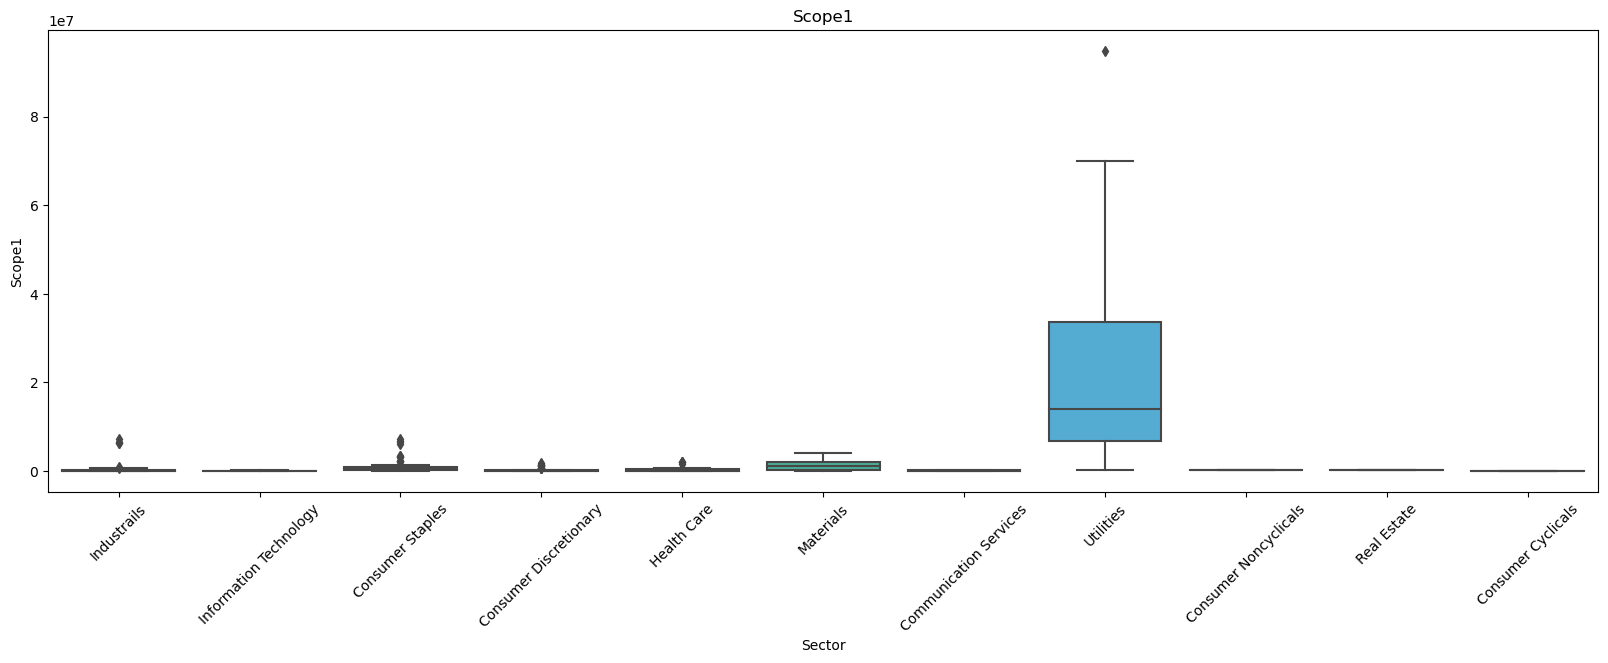

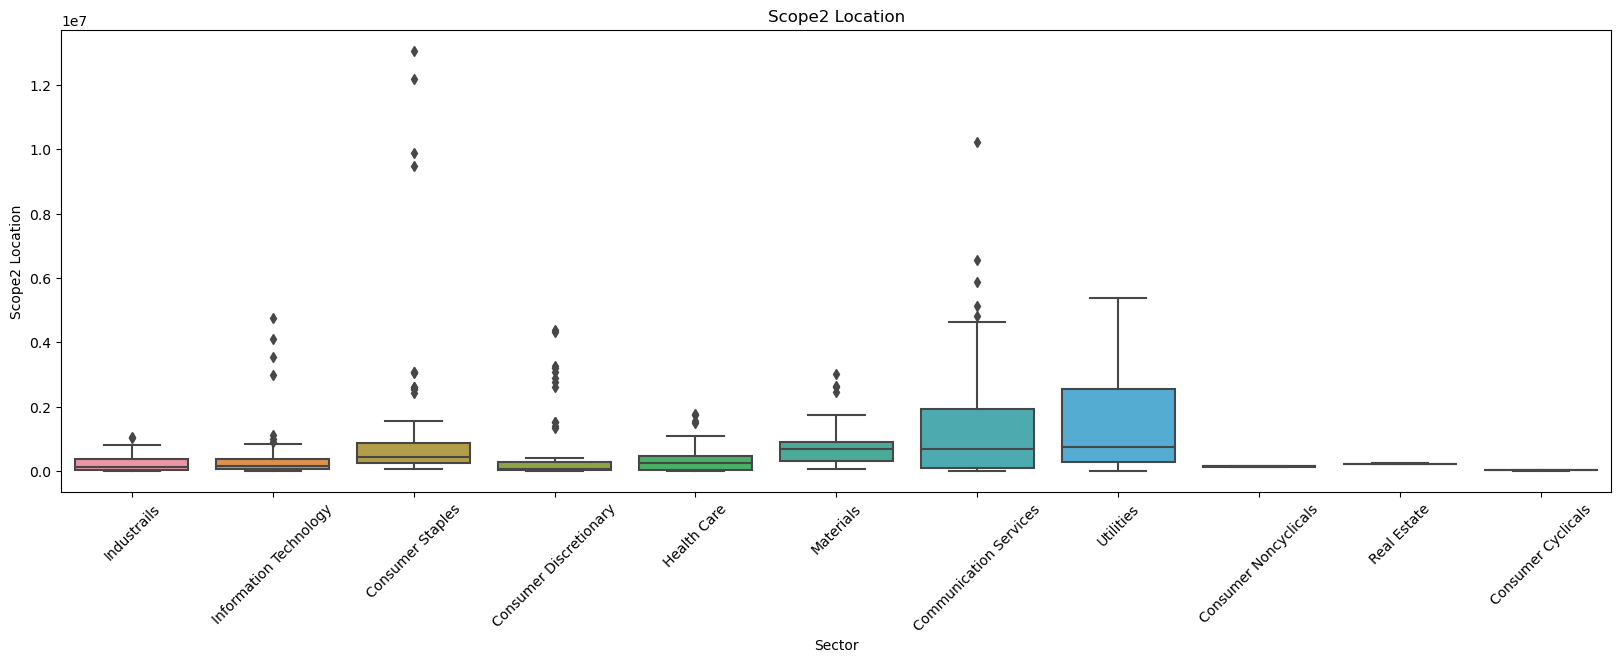

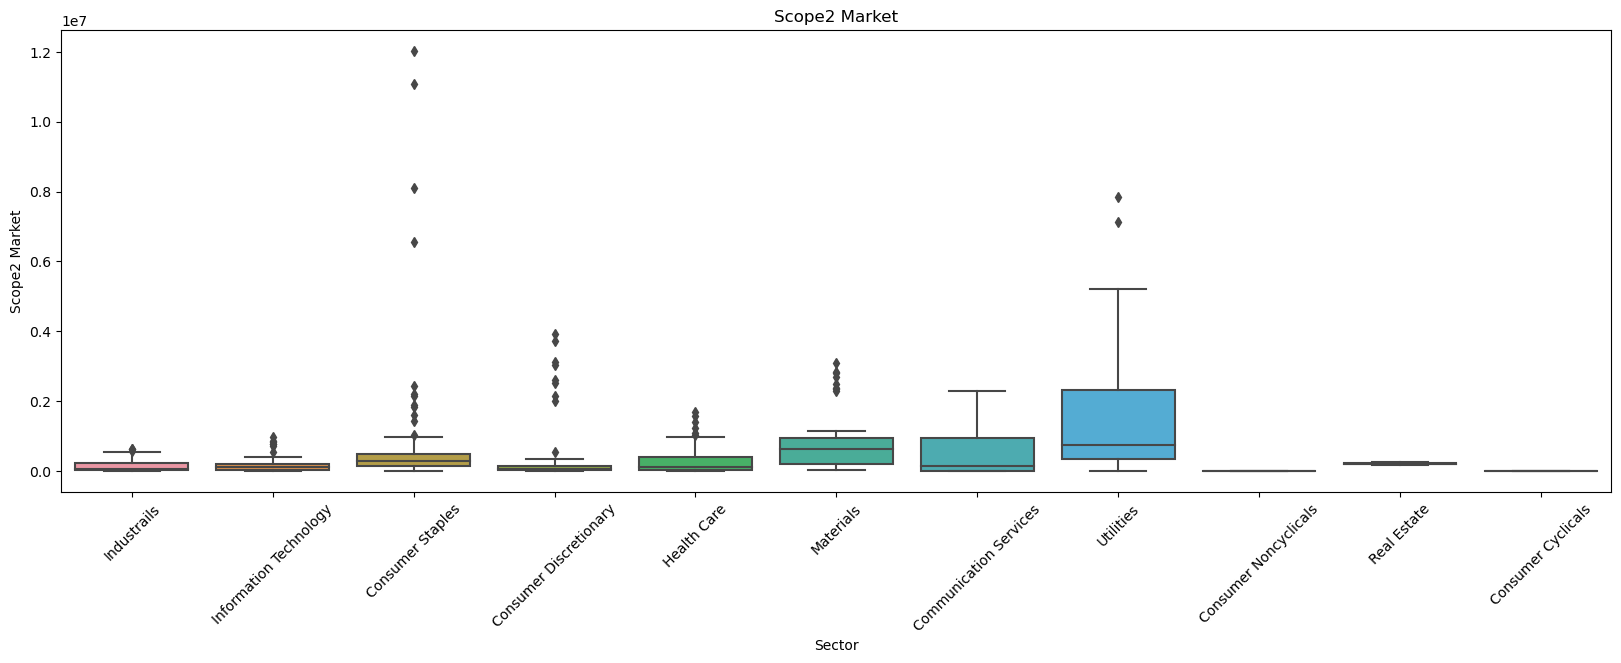

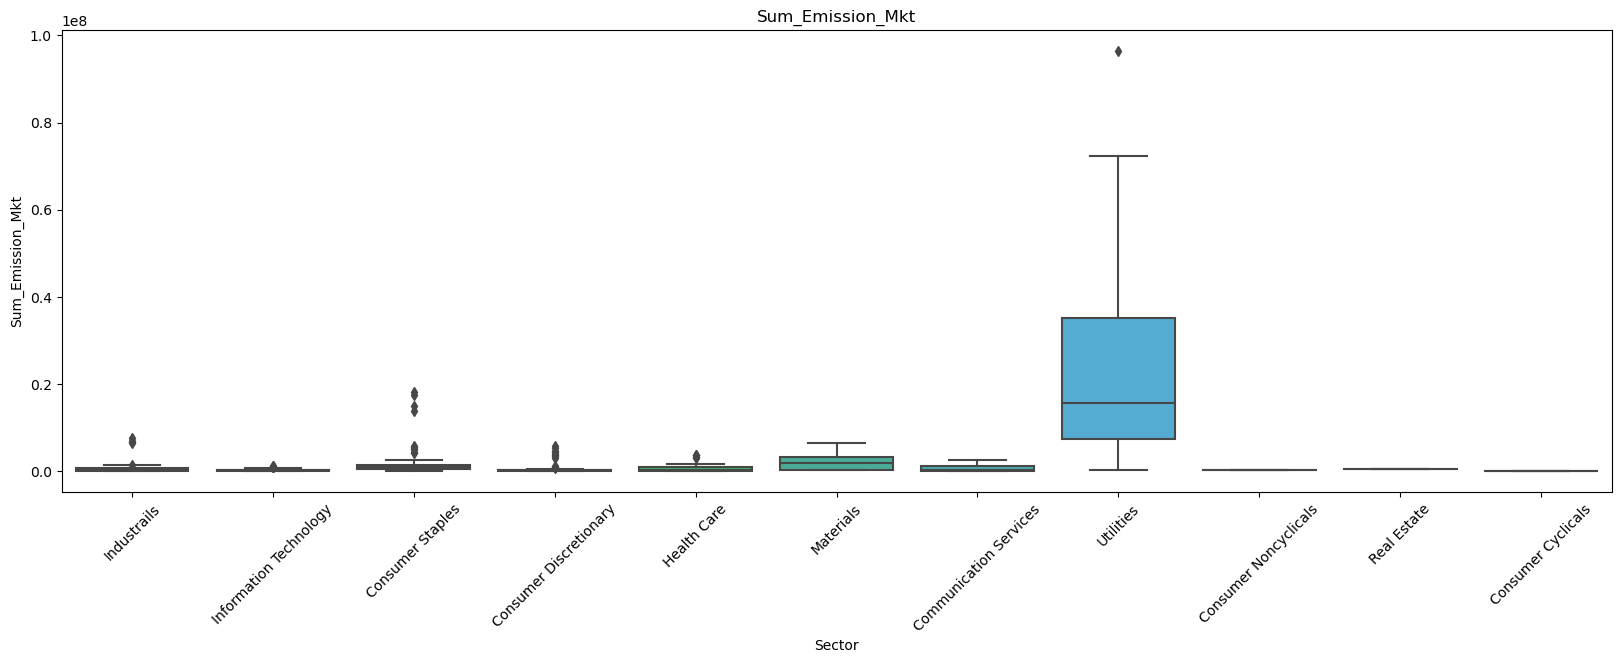

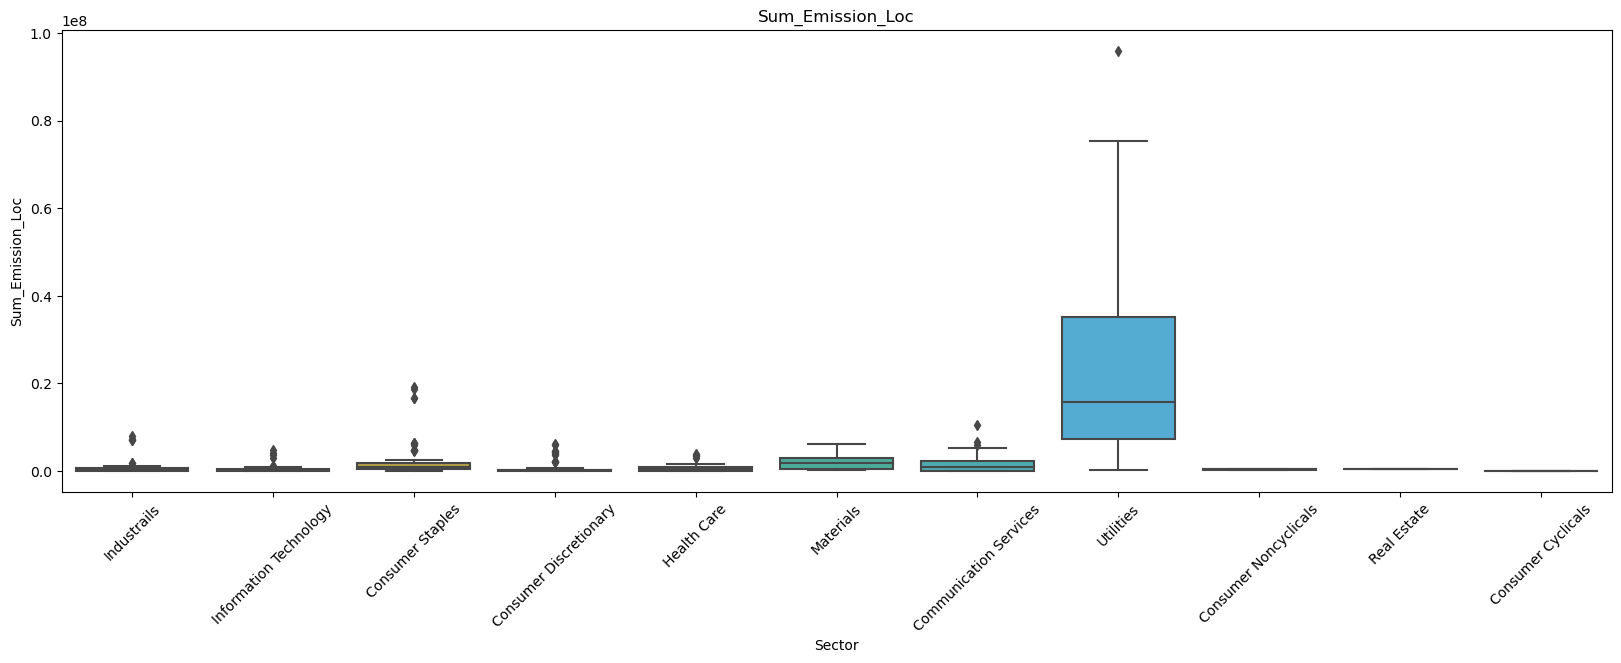

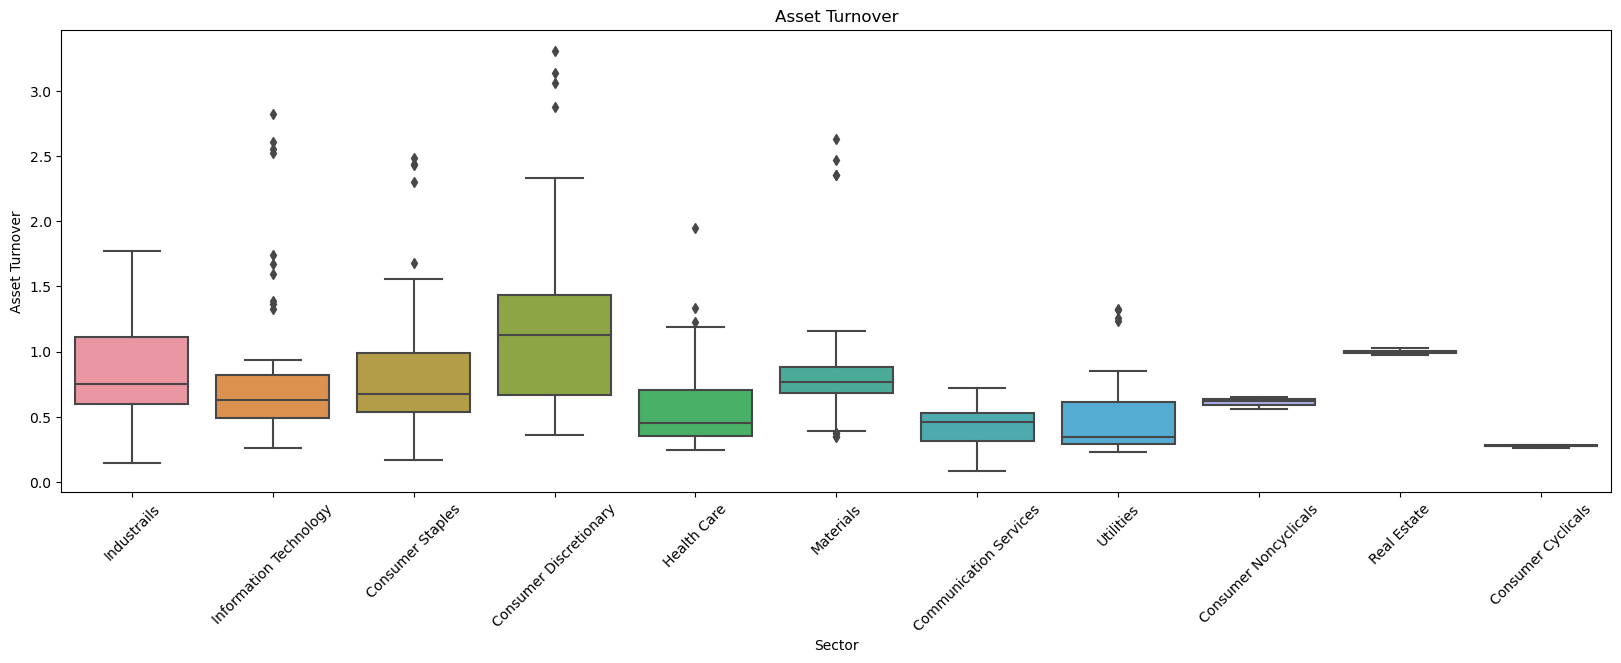

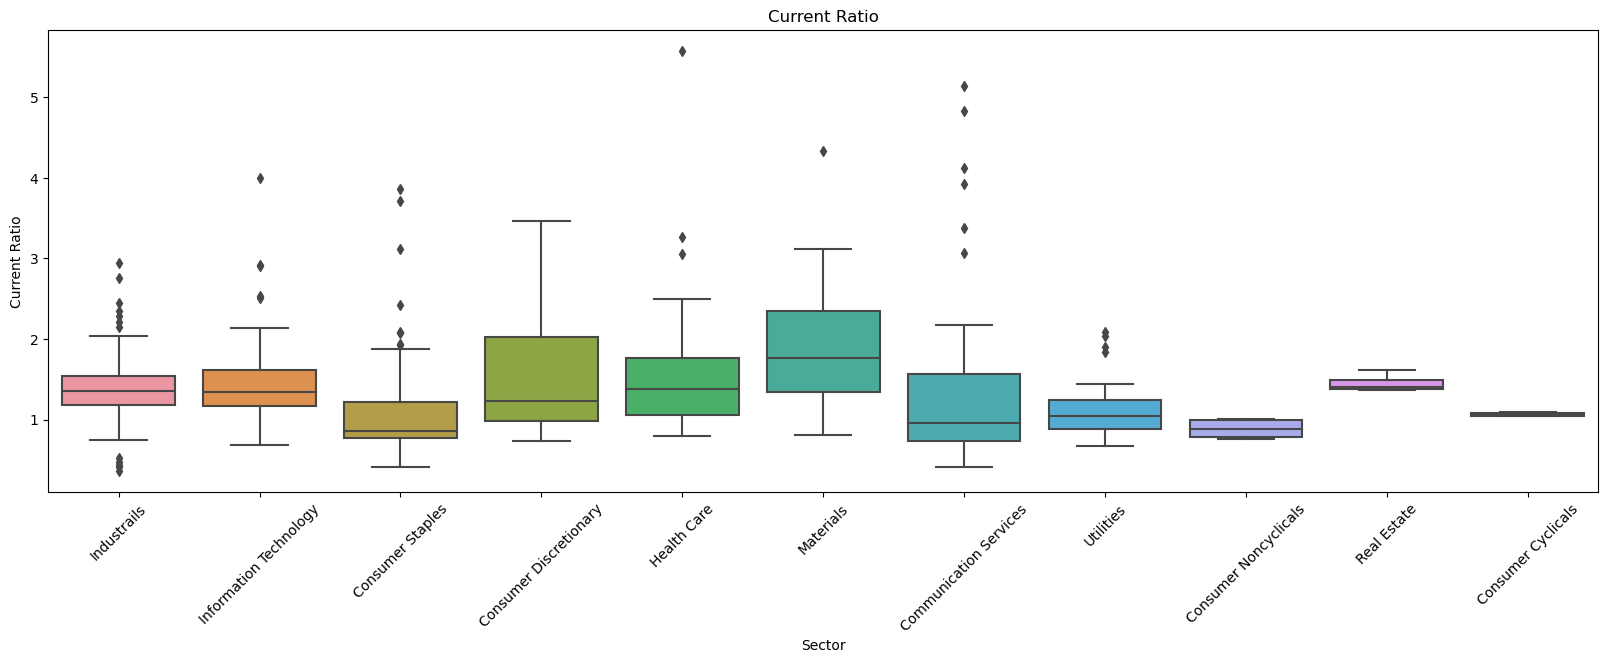

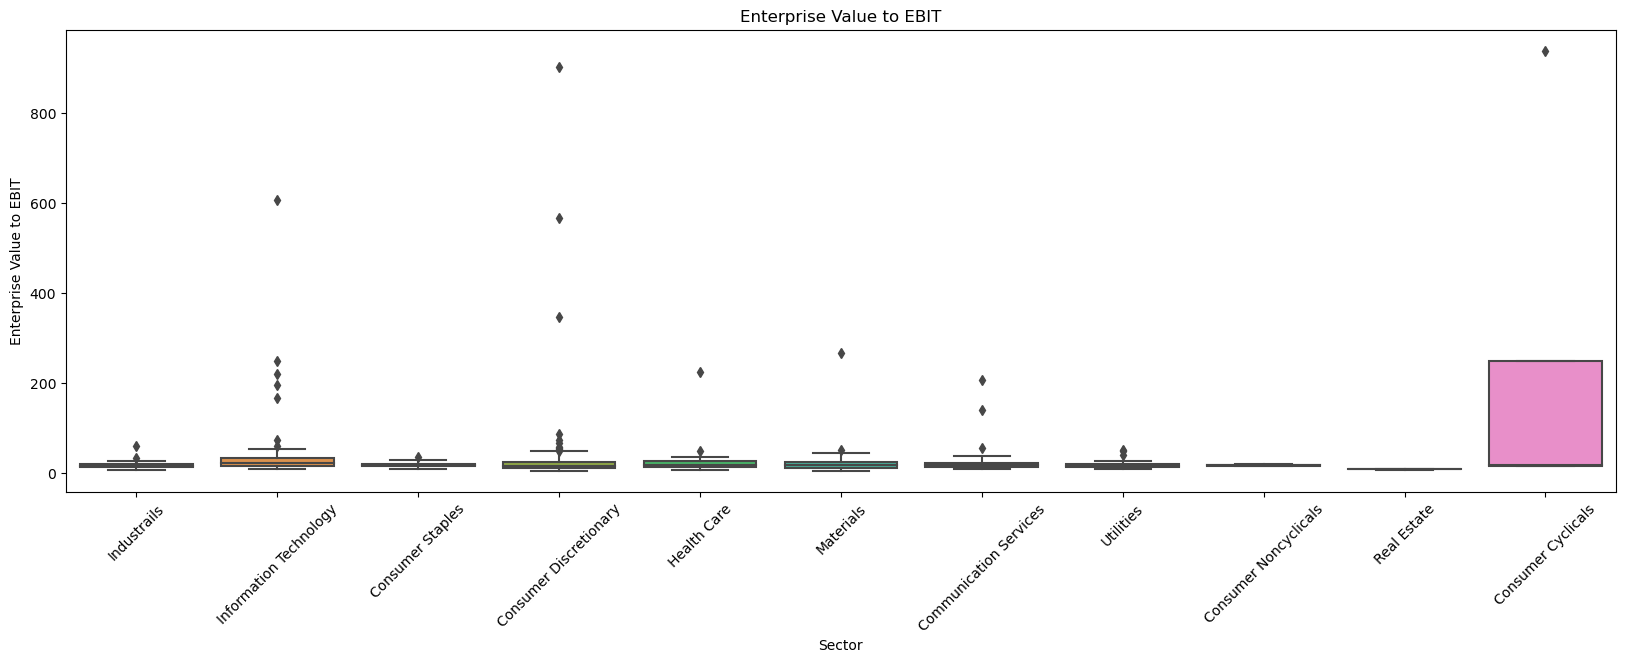

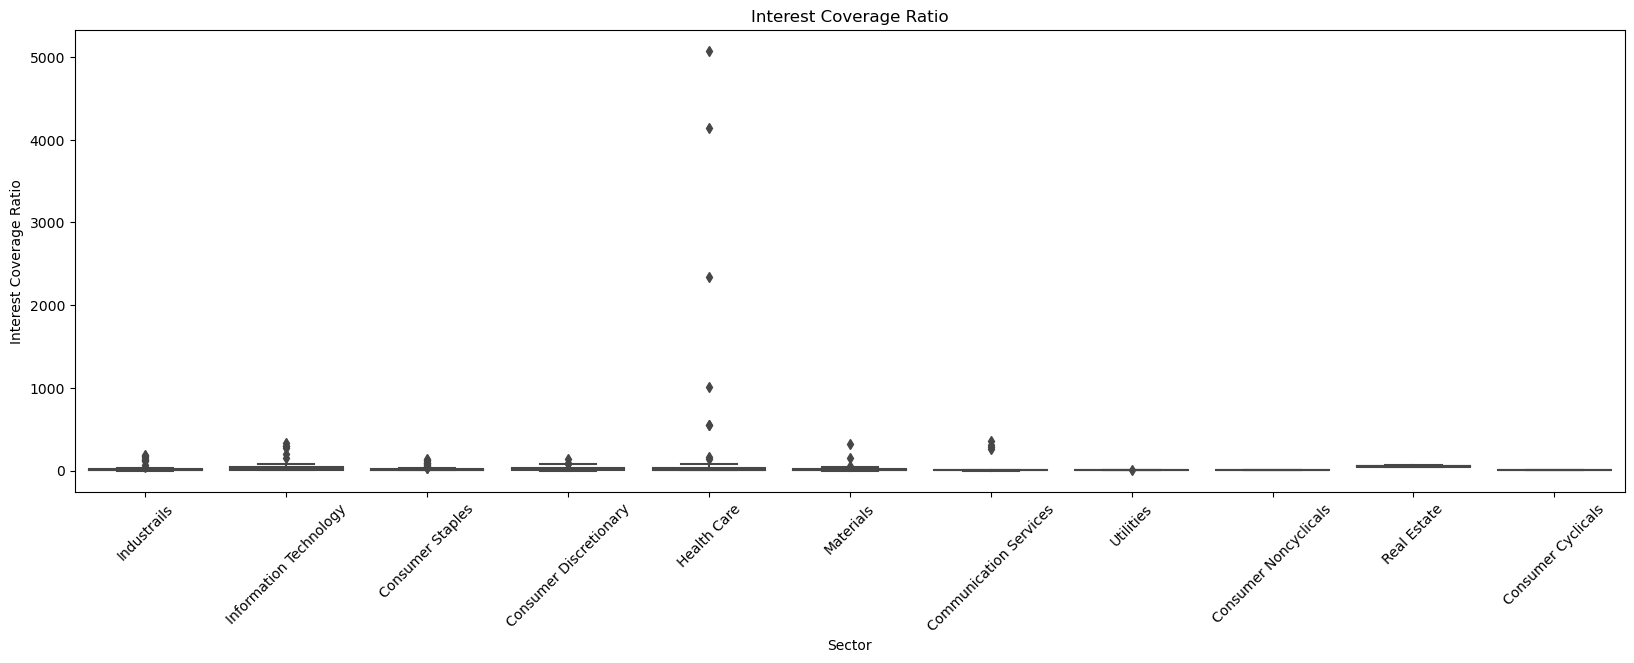

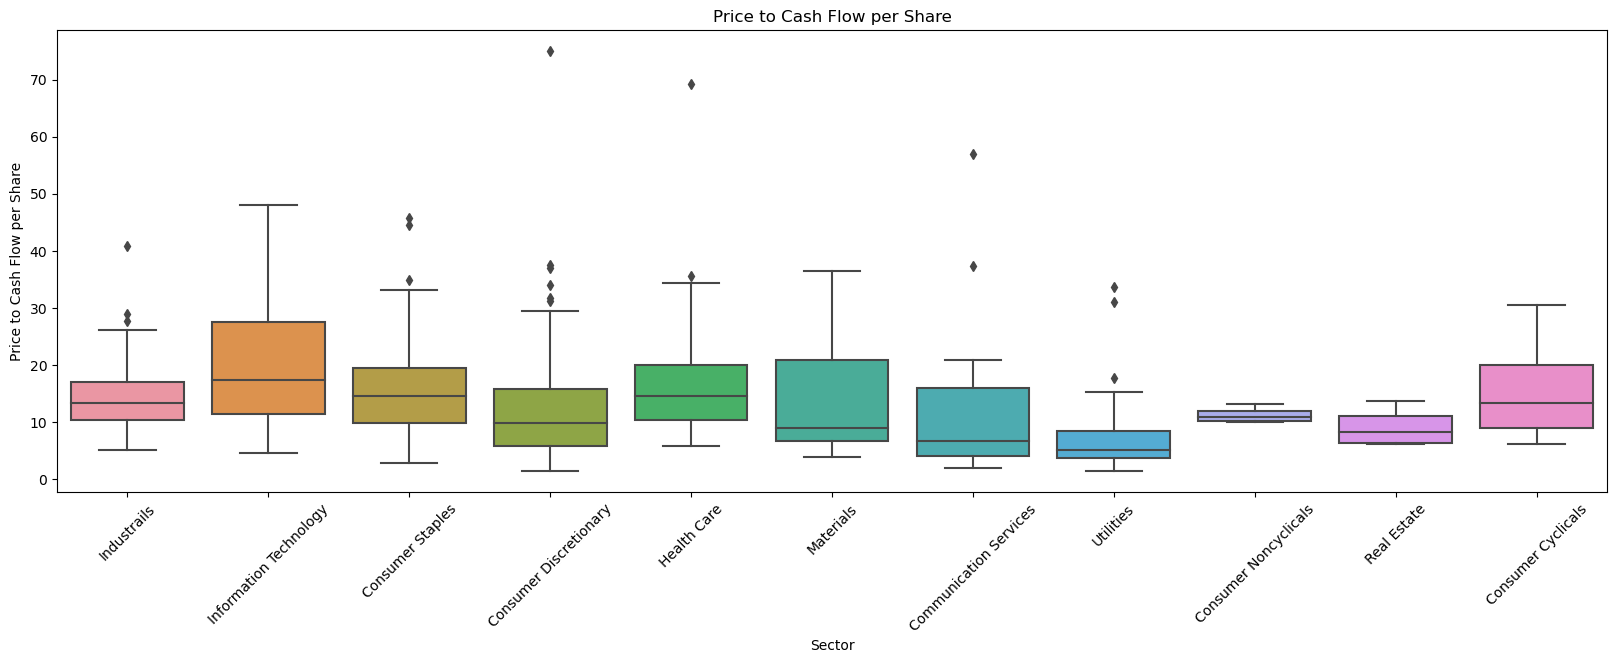

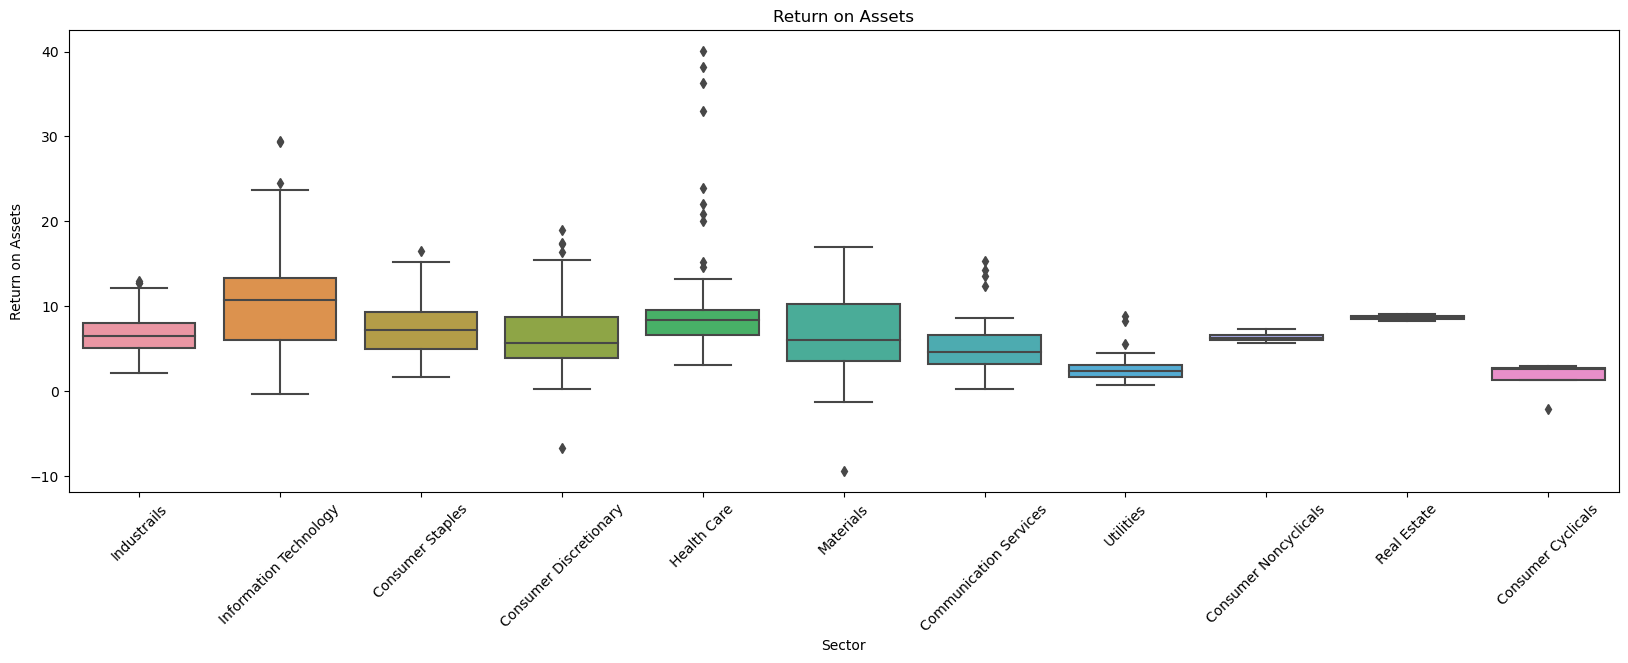

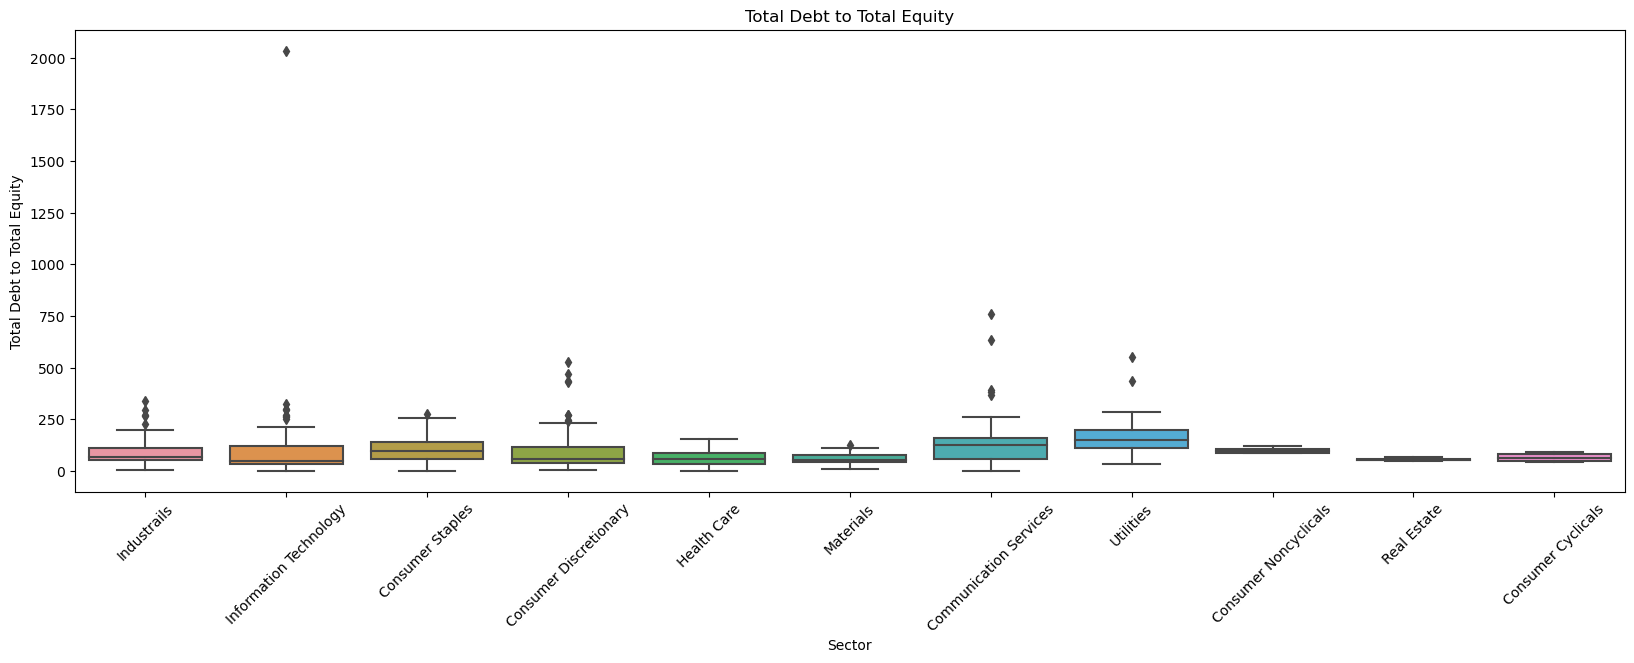

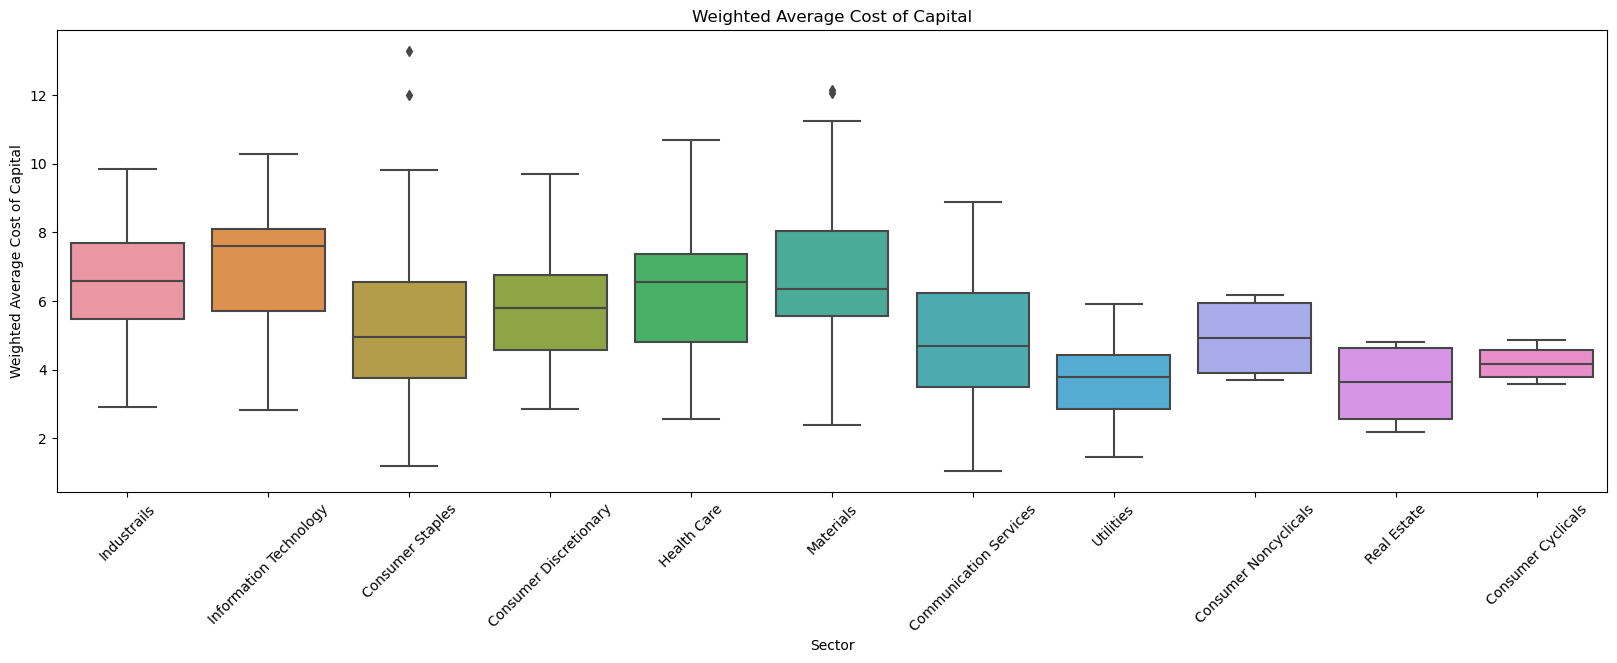

In [38]:
for metric in final_data.columns[1:]:
    plt.figure(figsize=(20,6))
    sns.boxplot(x='Sector', y=metric, data=final_data.reset_index())
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.show()

#### Heatmaps of Correlations
Plot a heatmap of the correlations for each sector

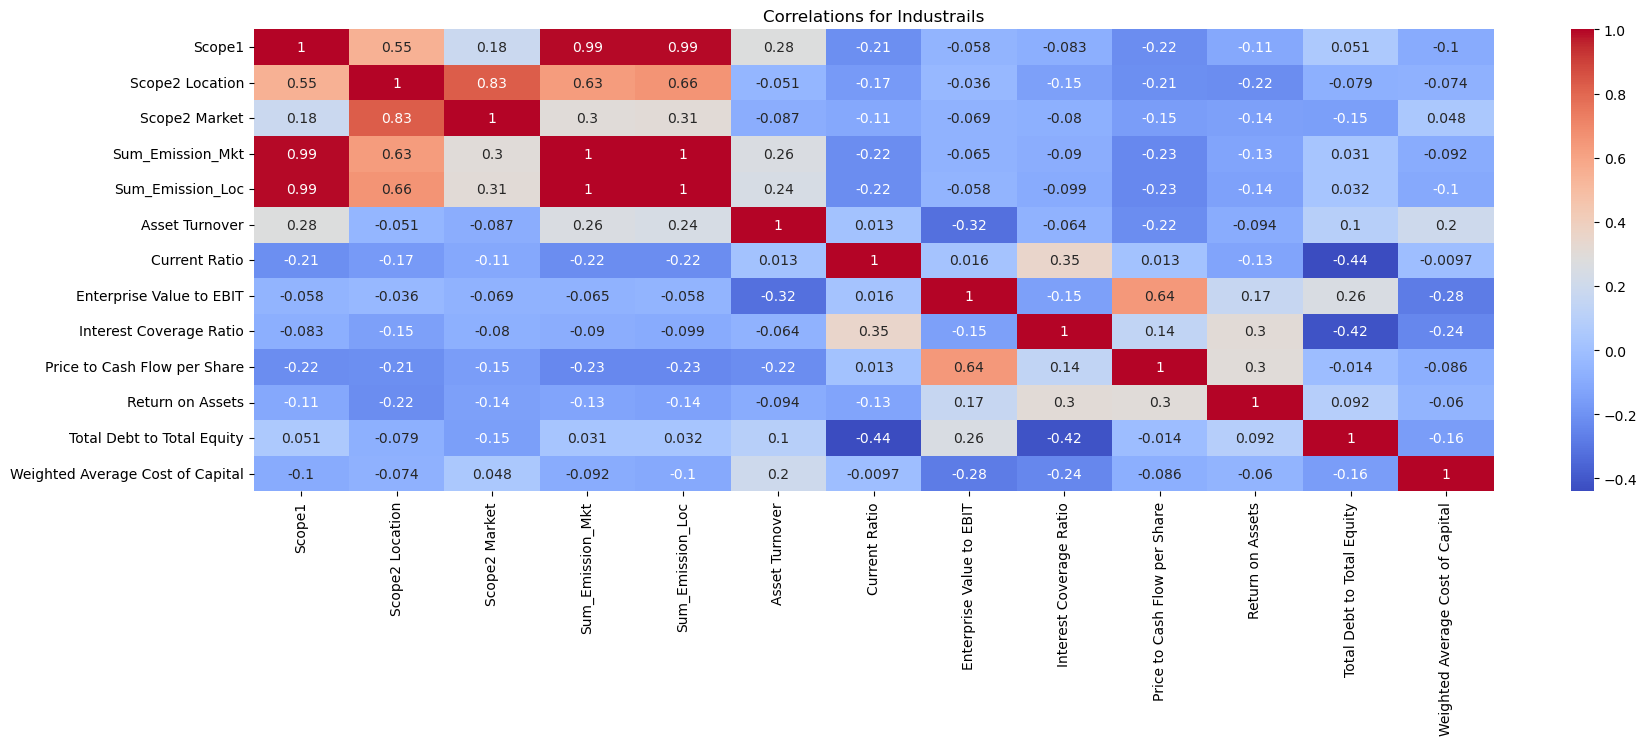

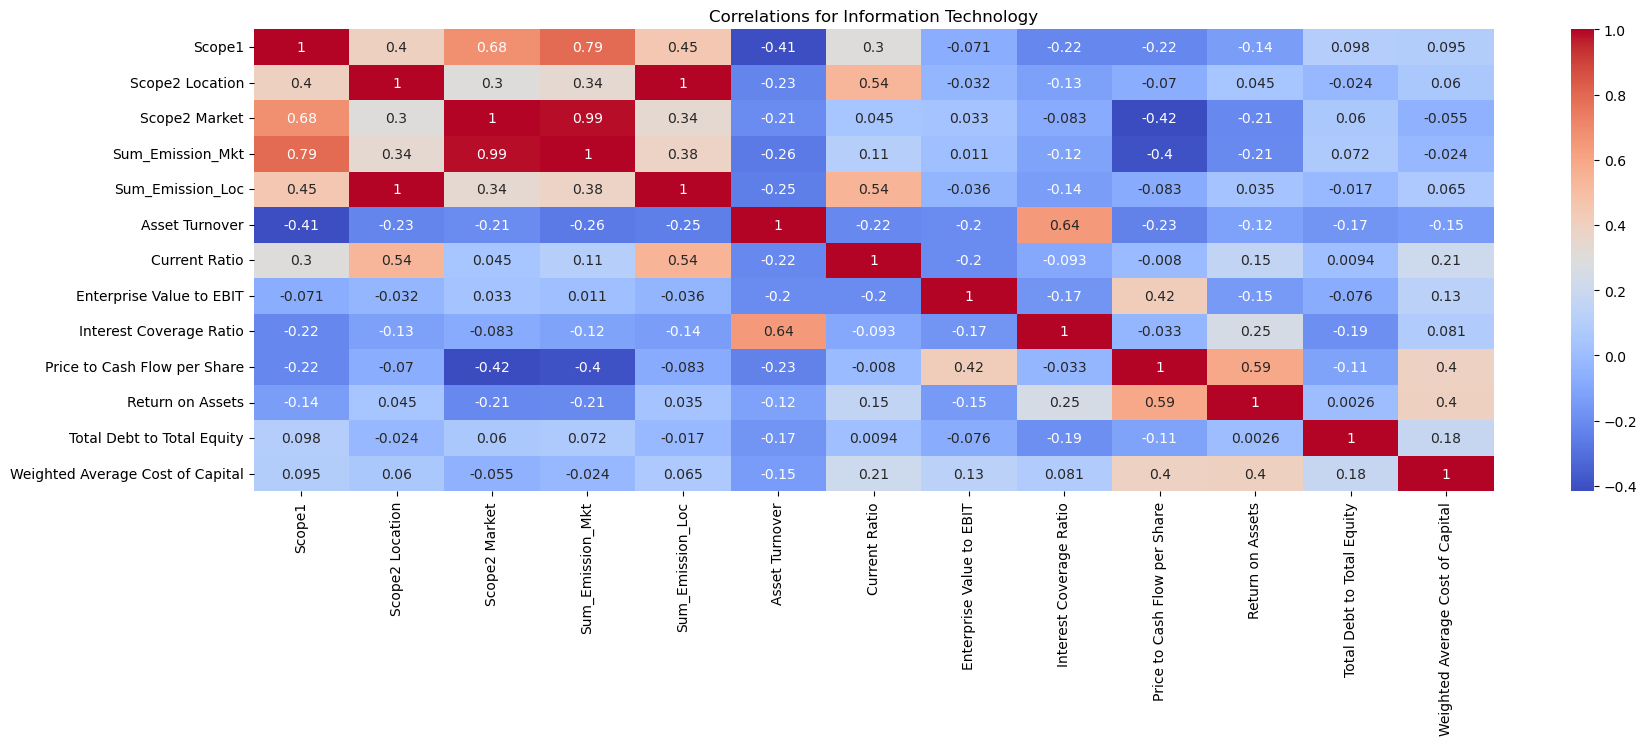

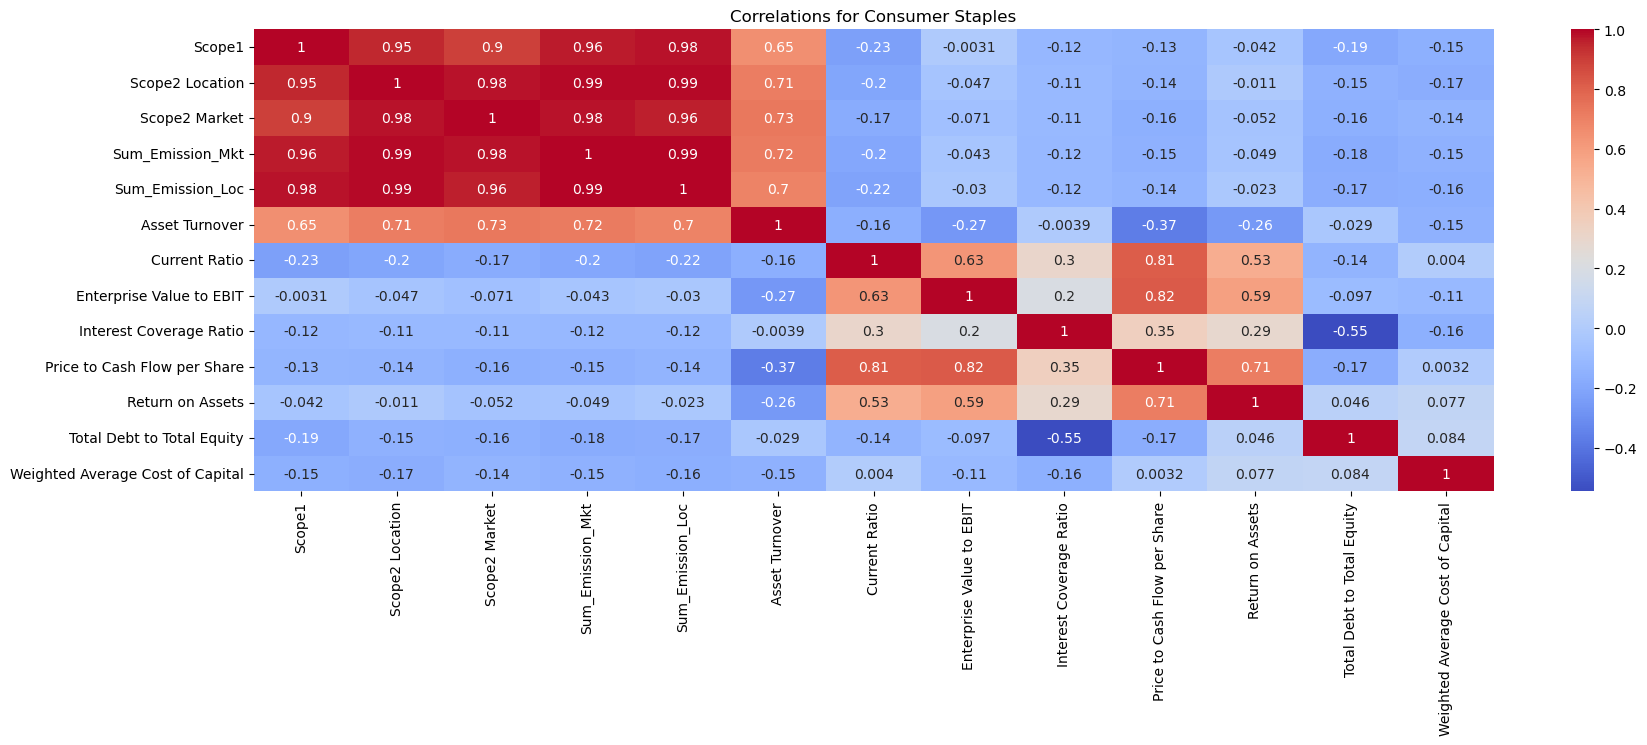

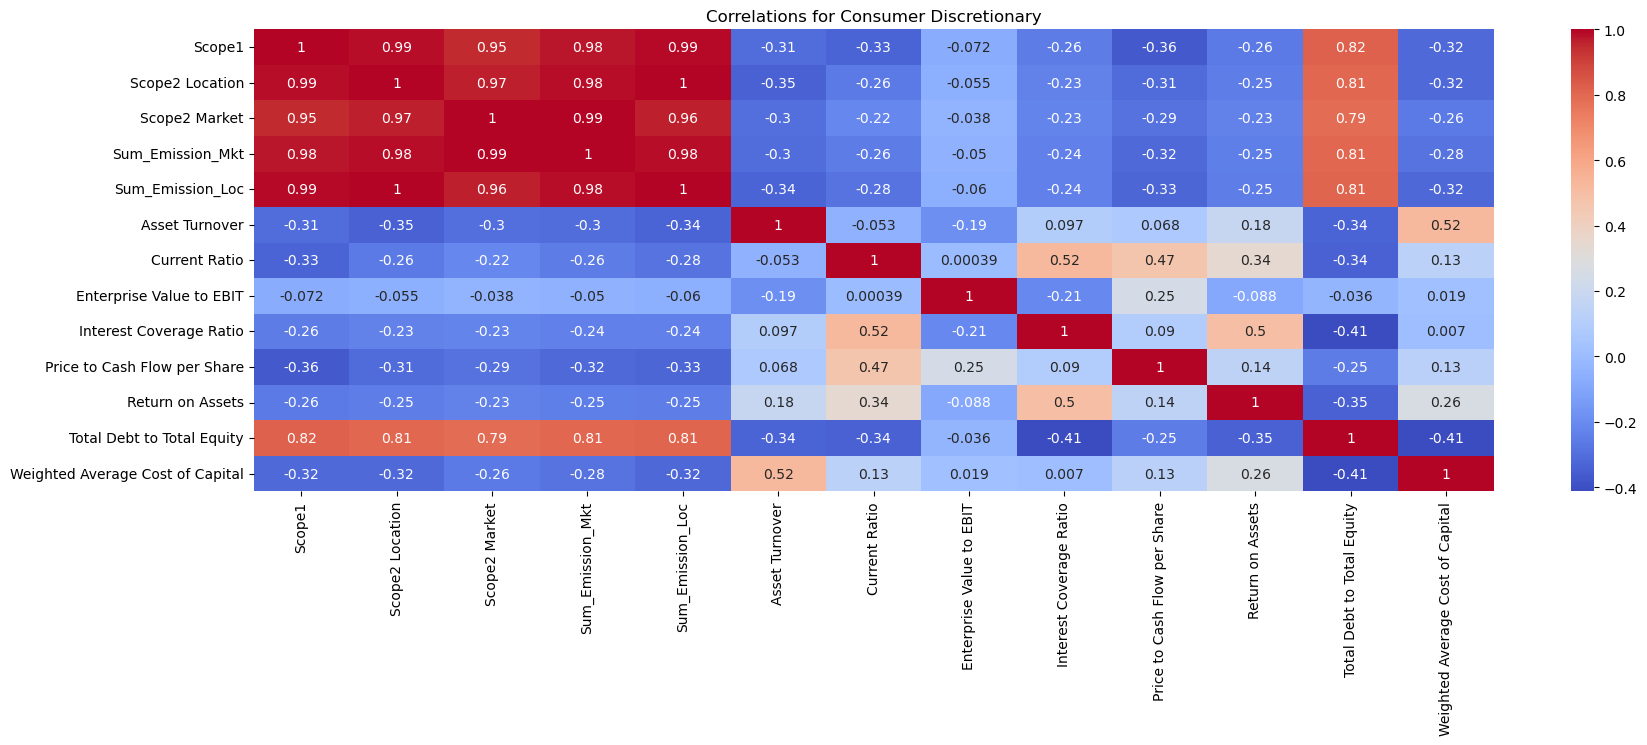

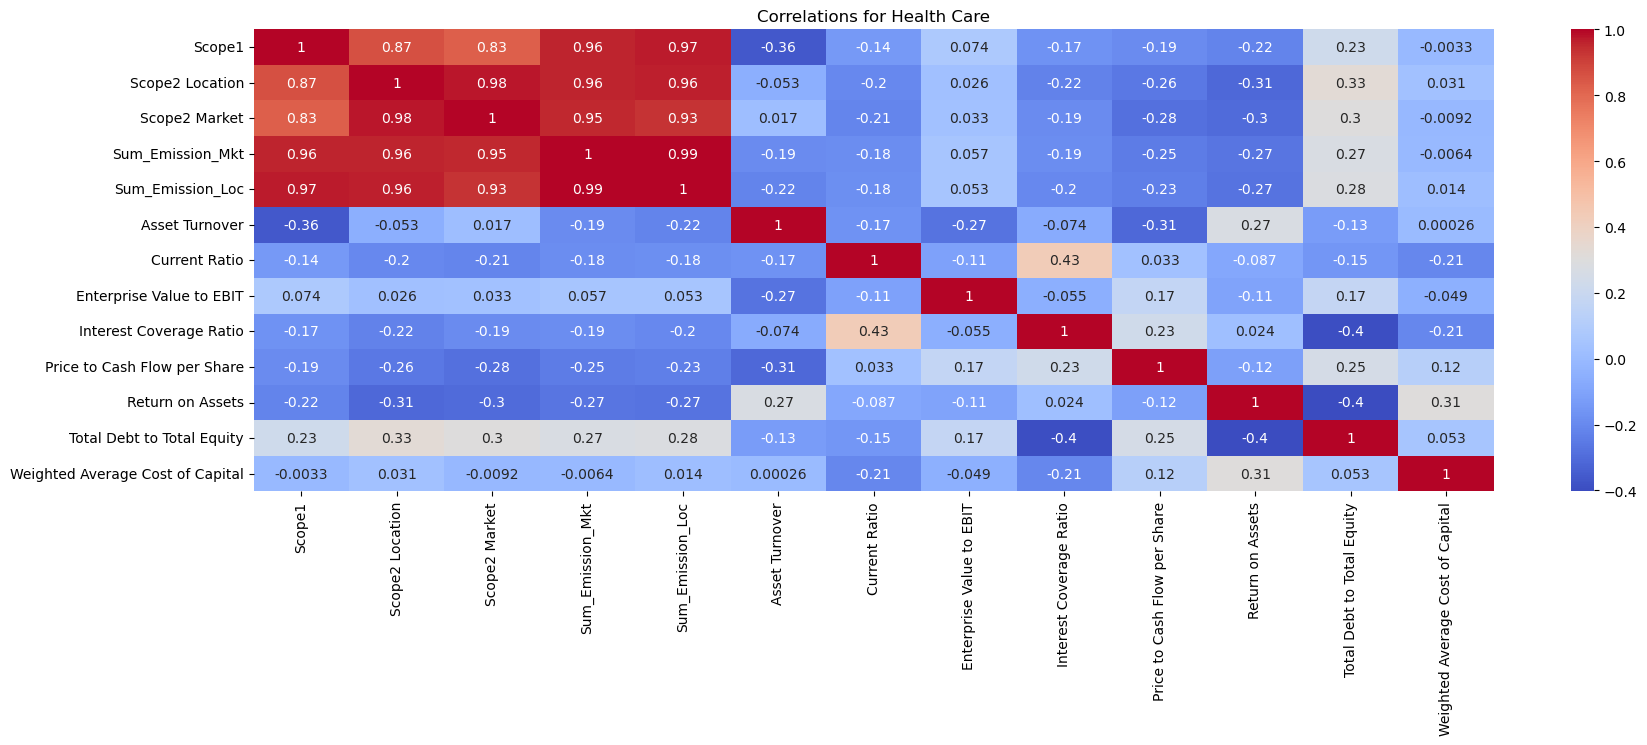

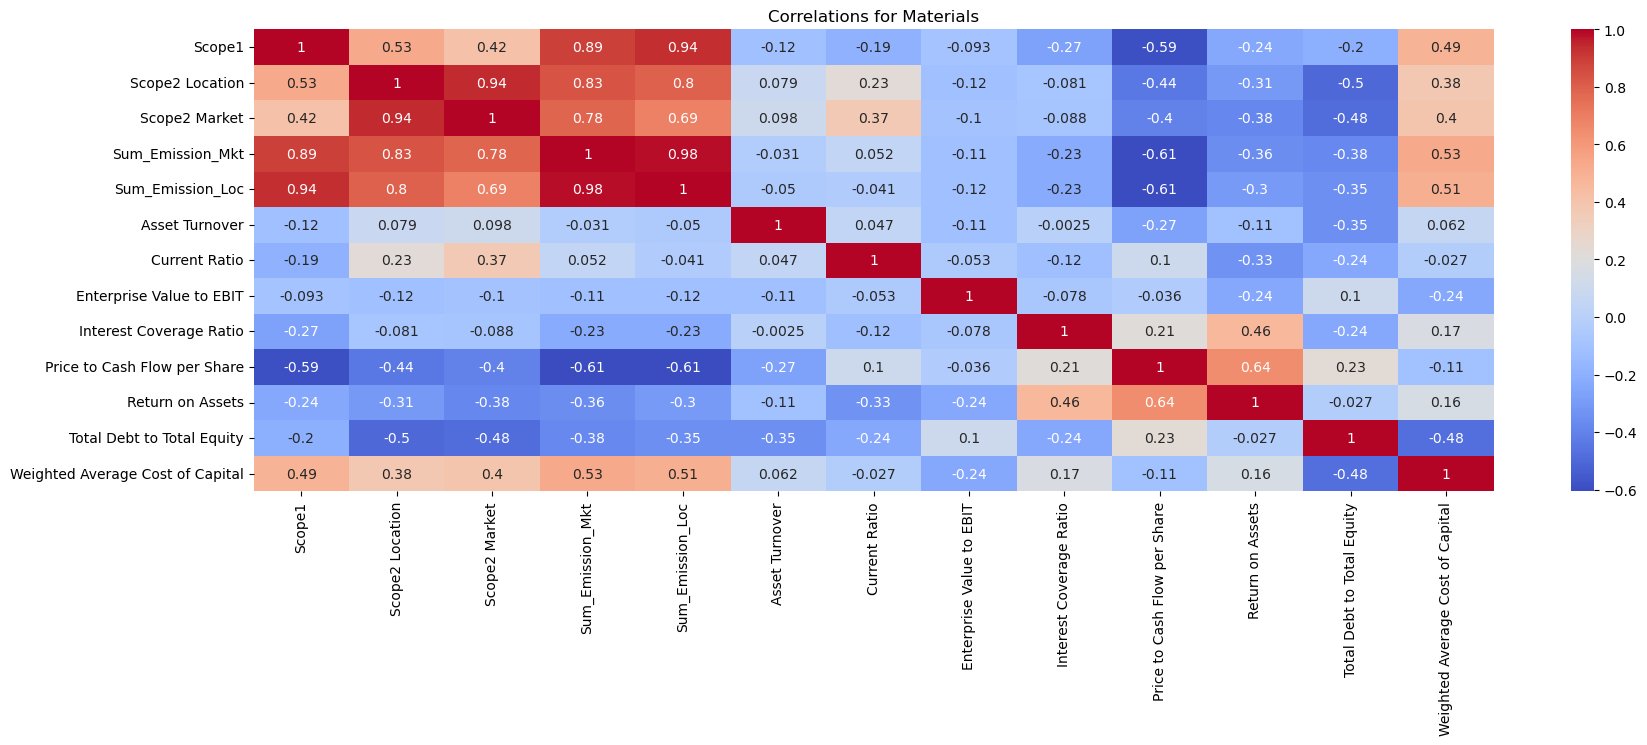

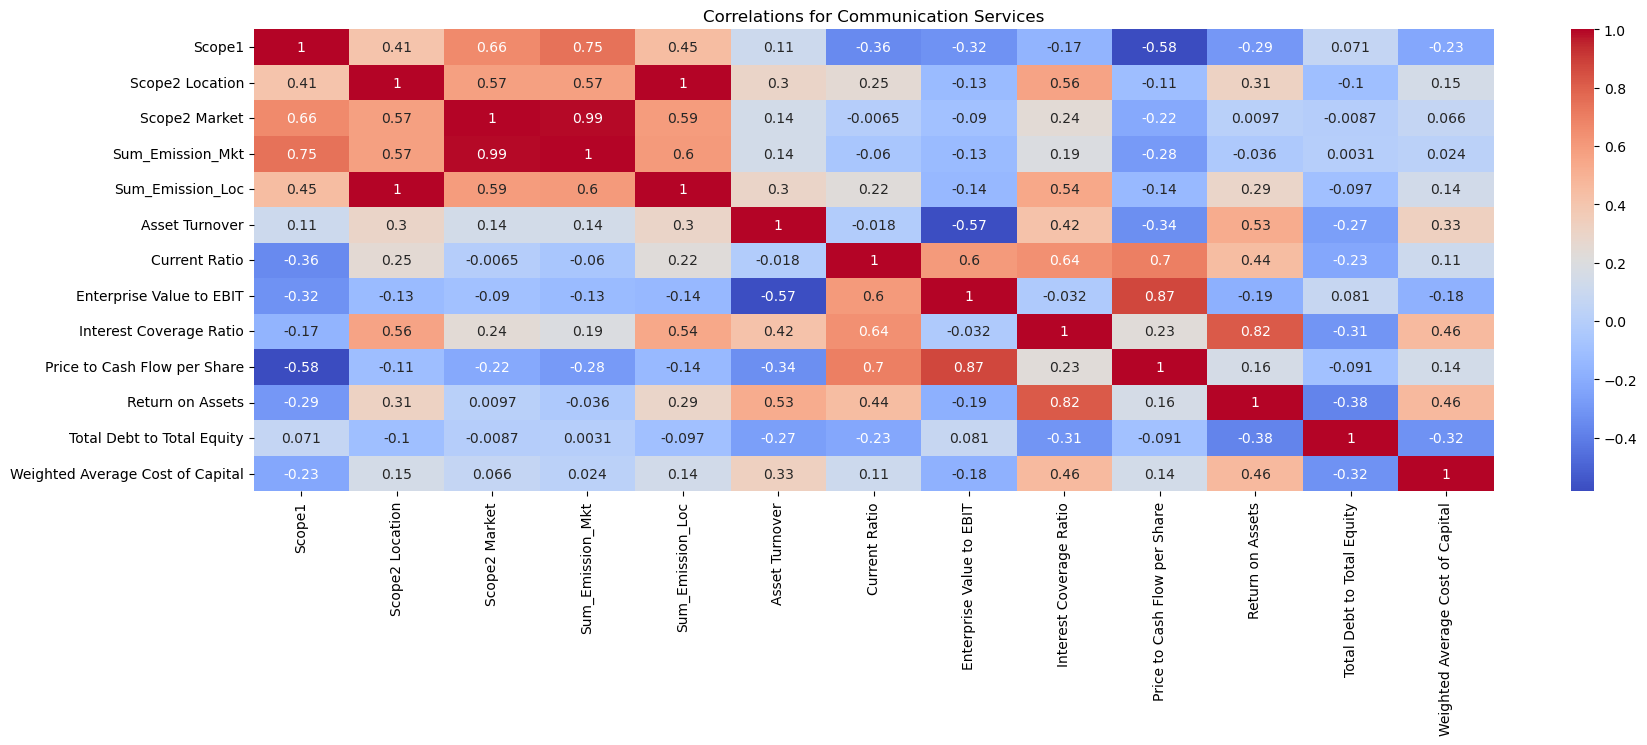

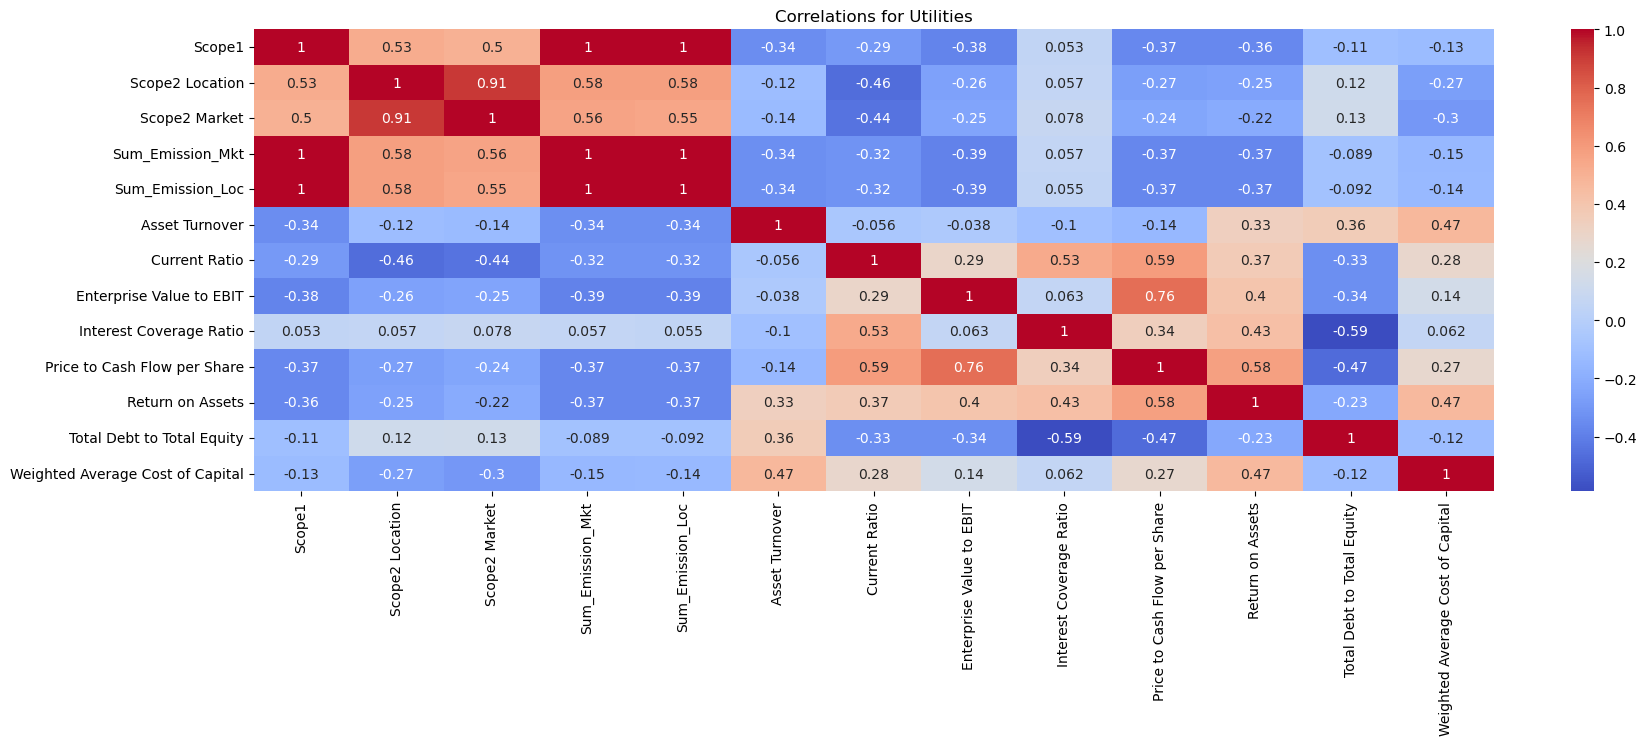

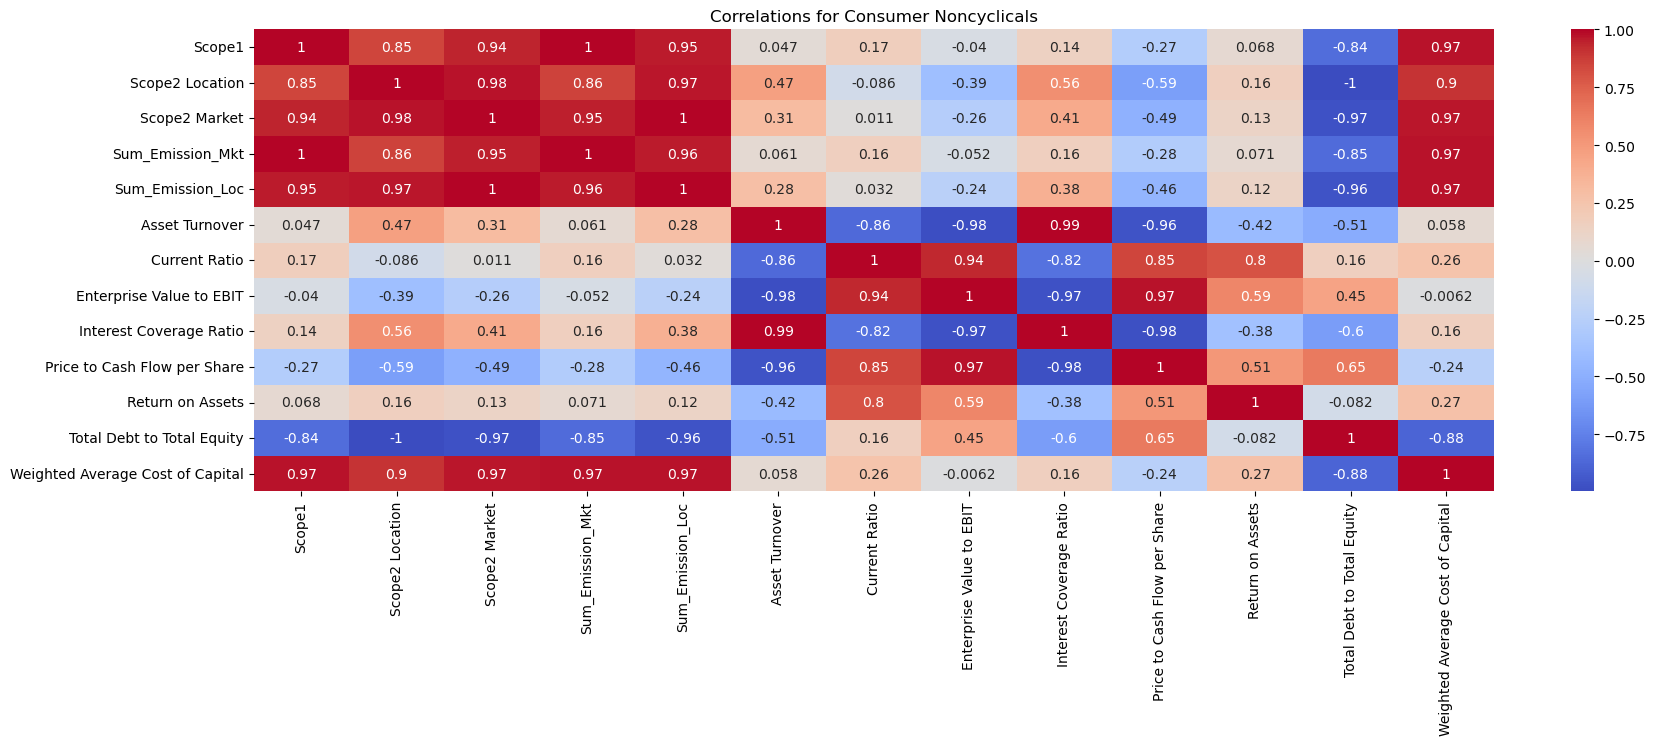

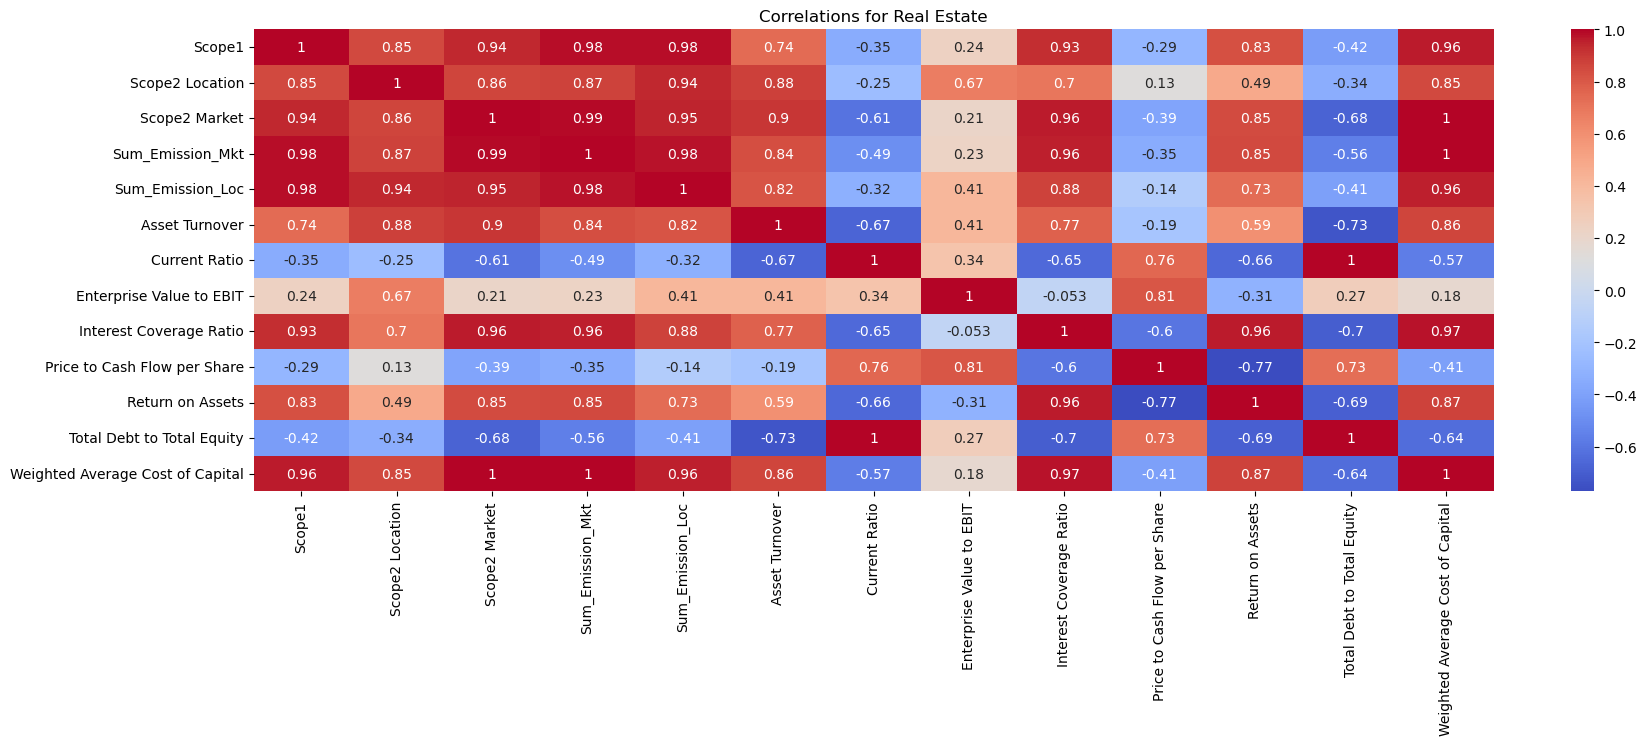

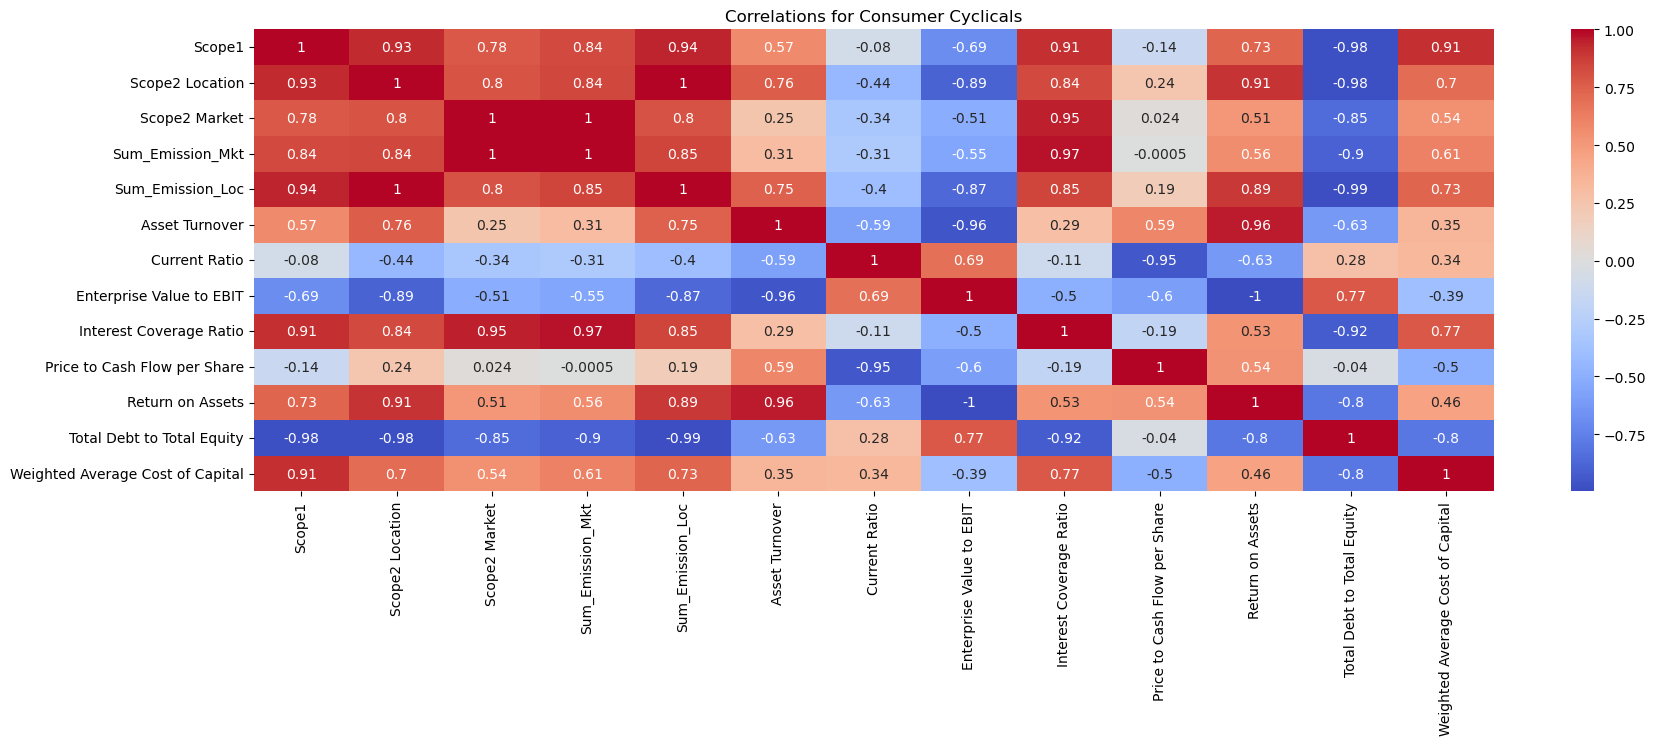

In [39]:
sectors = final_data.Sector.unique()
correlations_by_sector = {sector: final_data.loc[final_data.Sector == sector][final_data.columns[1:]].corr() for sector in sectors}
for sector, correlations in correlations_by_sector.items():
    plt.figure(figsize=(20,6))
    sns.heatmap(correlations, annot=True, cmap='coolwarm')
    plt.title(f'Correlations for {sector}')
    plt.show()

#### Company Distribution Across Sectors

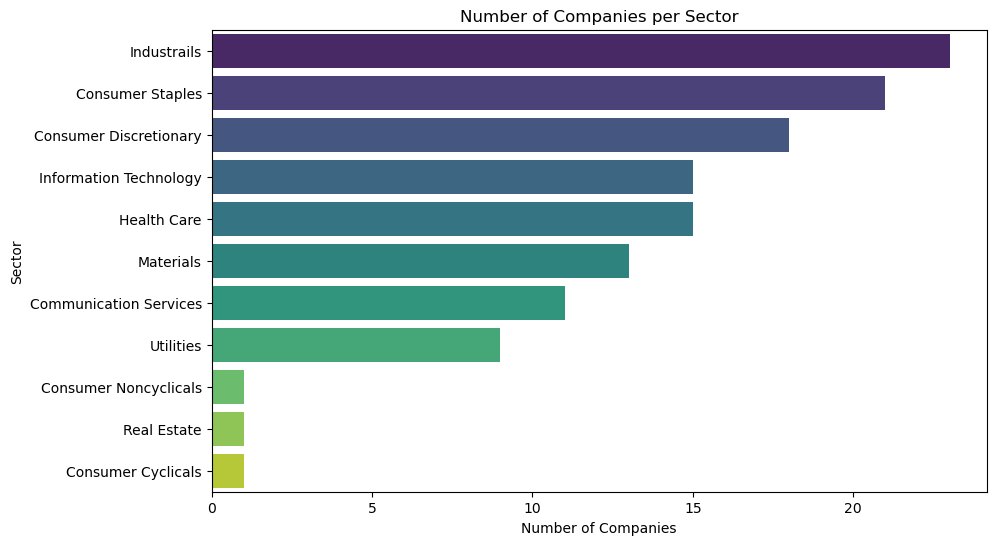

In [40]:
# Count the number of unique companies per sector
sectors = final_data[final_data.index.get_level_values('Year')==2018]
company_count_per_sector = sectors['Sector'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(x=company_count_per_sector.values, y=company_count_per_sector.index, palette='viridis')
plt.title('Number of Companies per Sector')
plt.xlabel('Number of Companies')
plt.ylabel('Sector')
plt.show()

#### Heatmap Sector Performance
Visualise sector performance over time using heatmaps

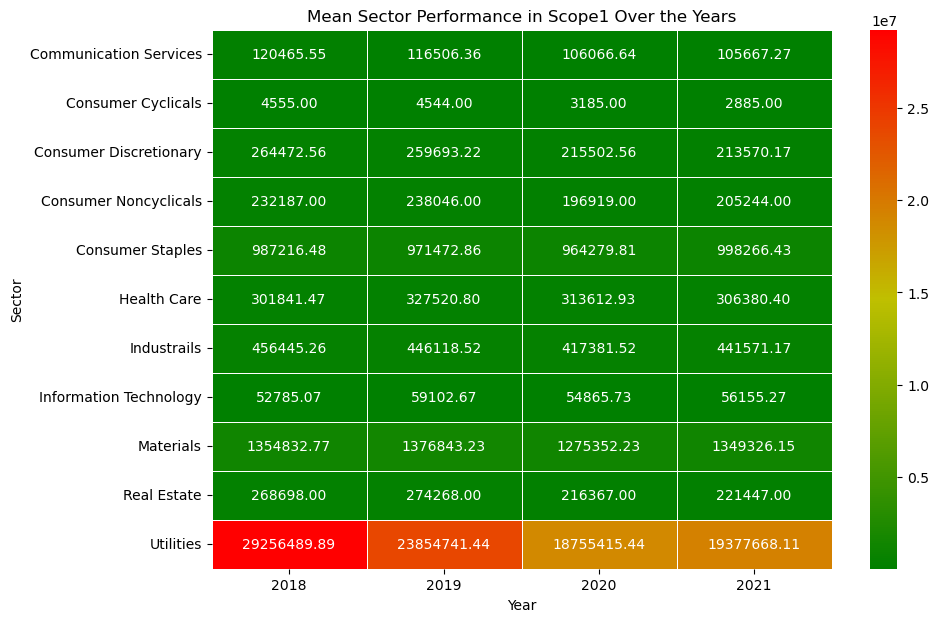

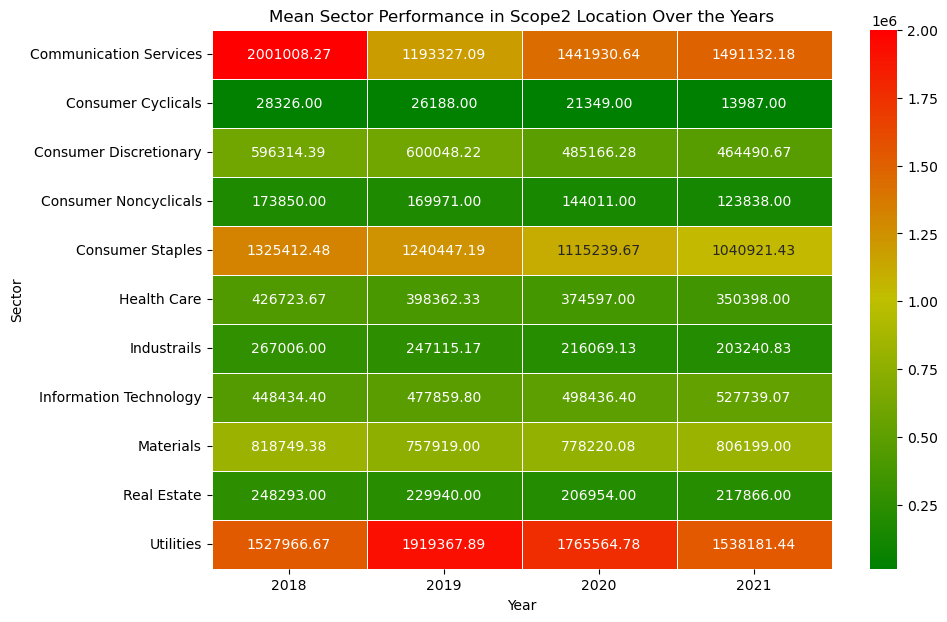

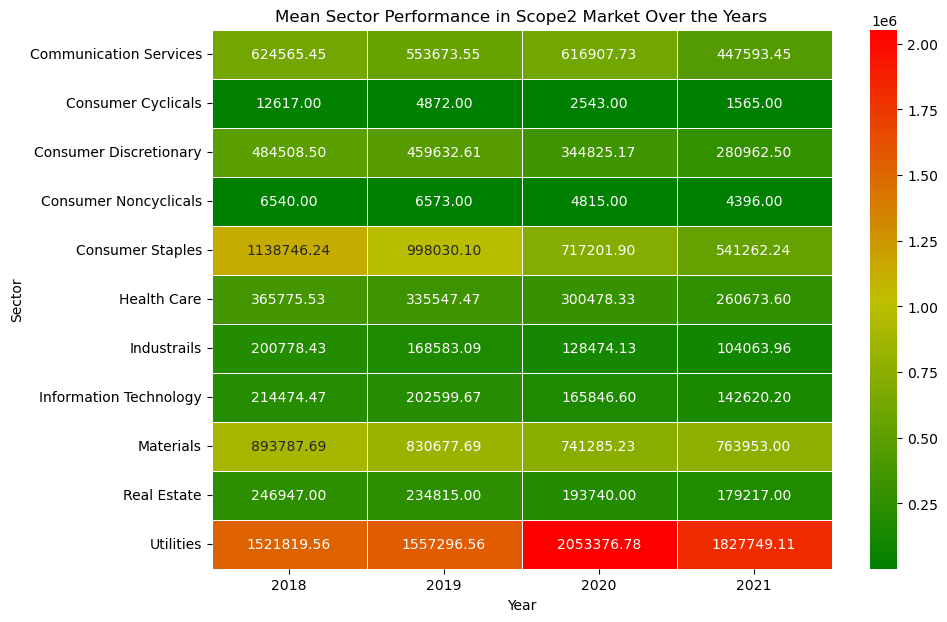

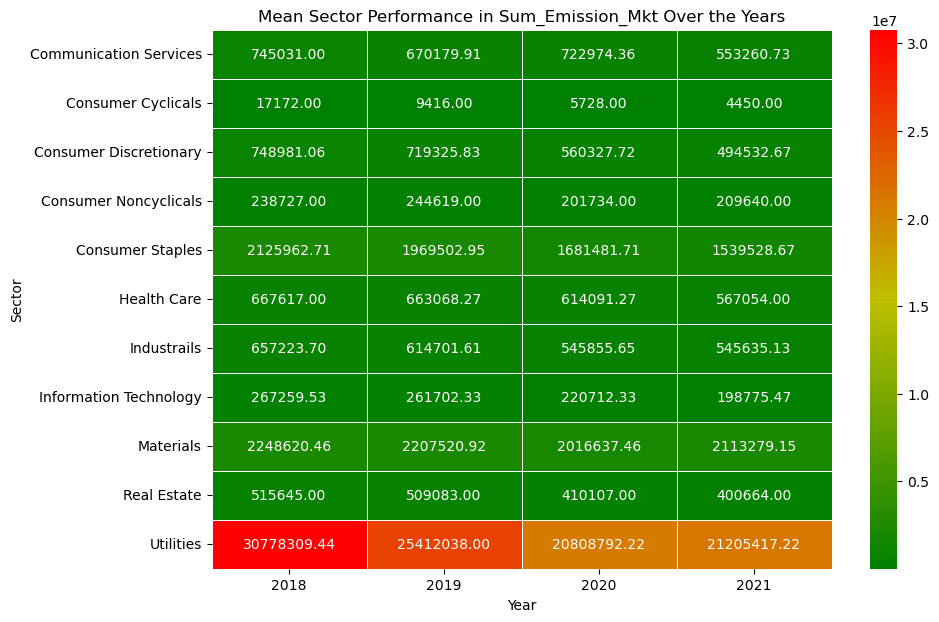

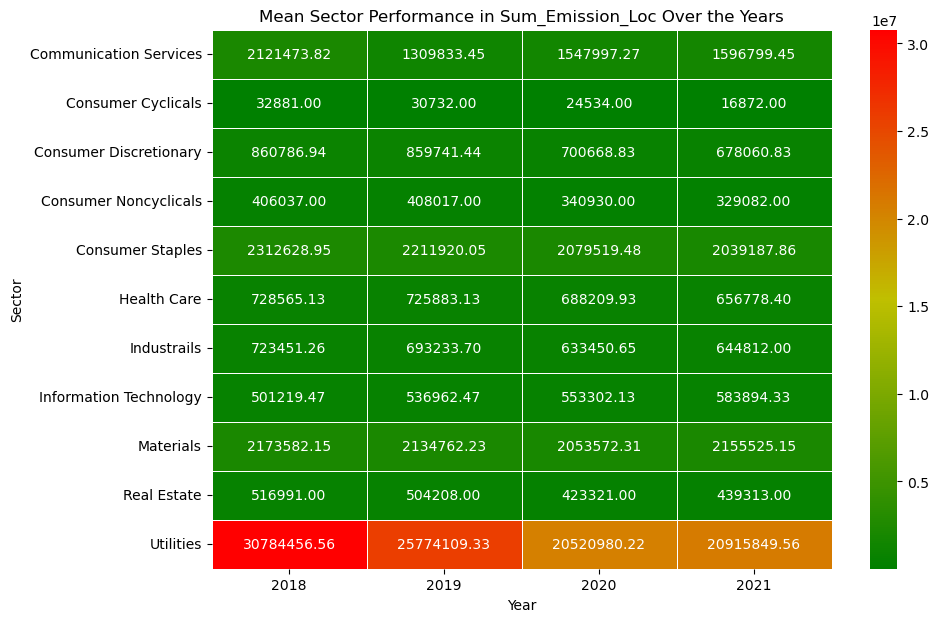

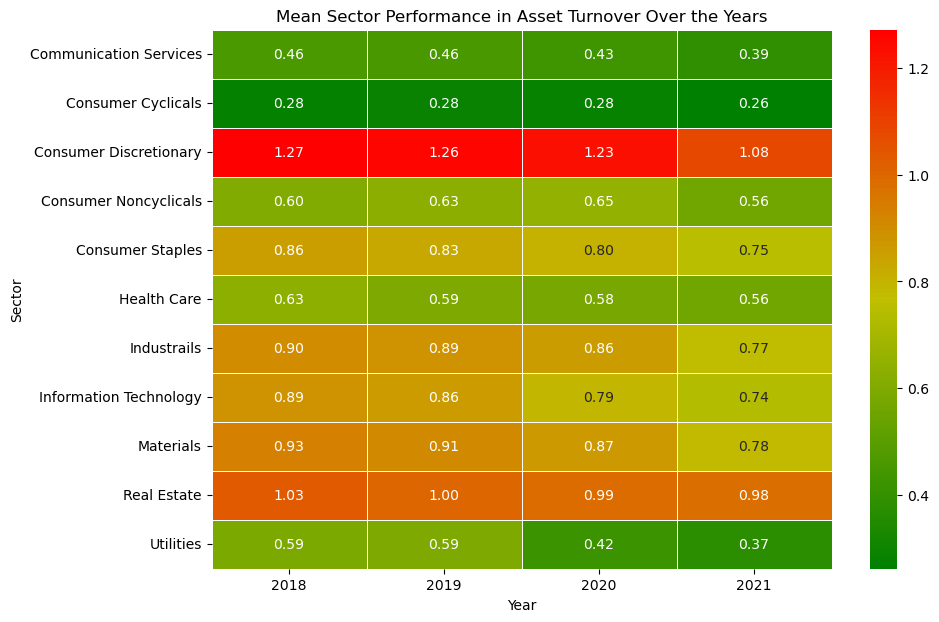

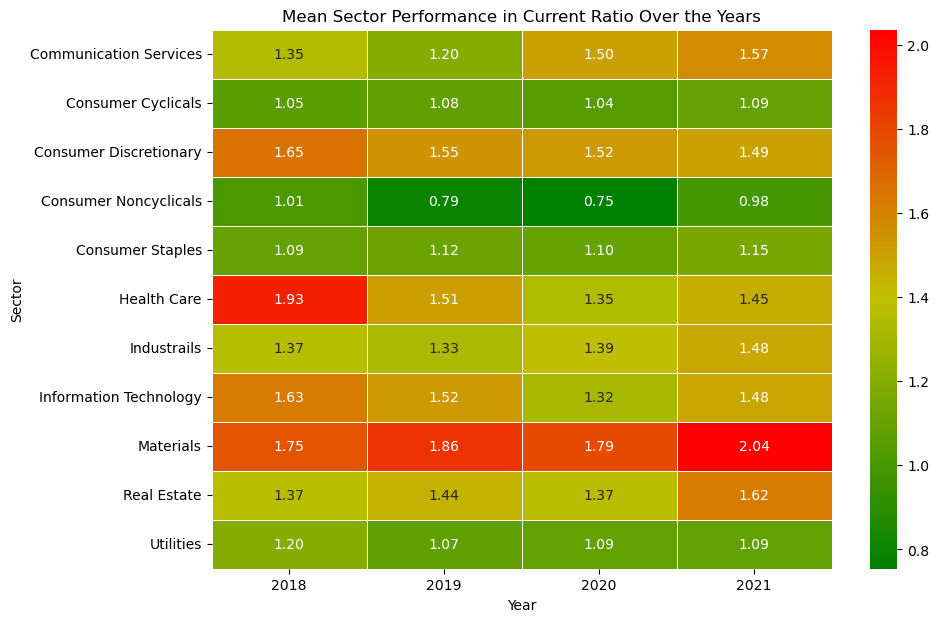

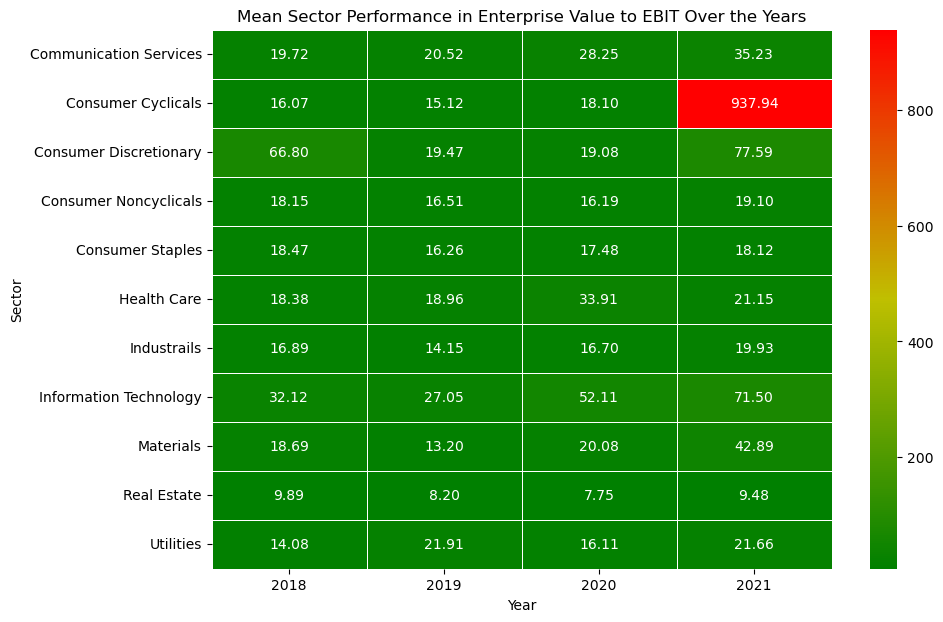

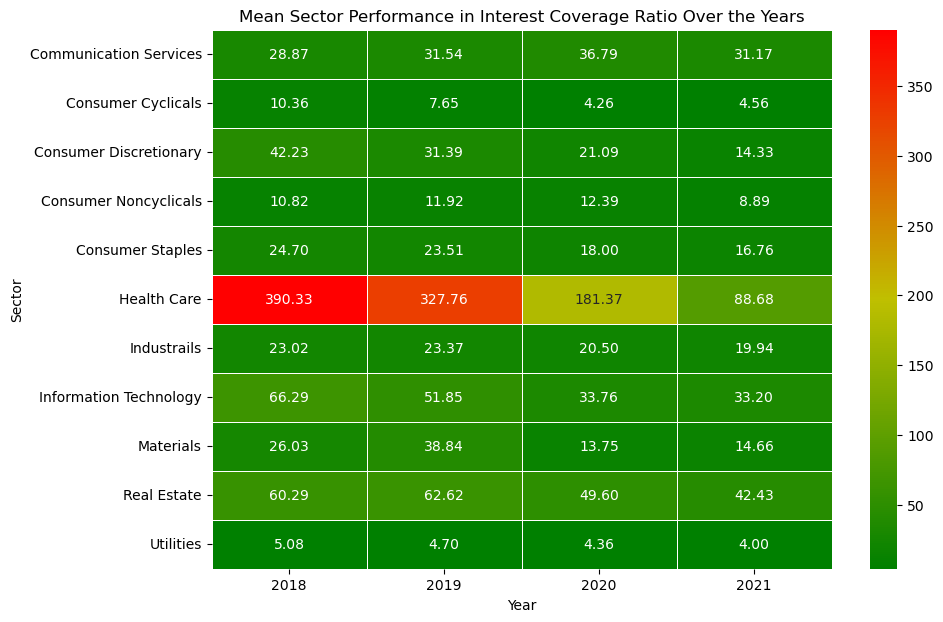

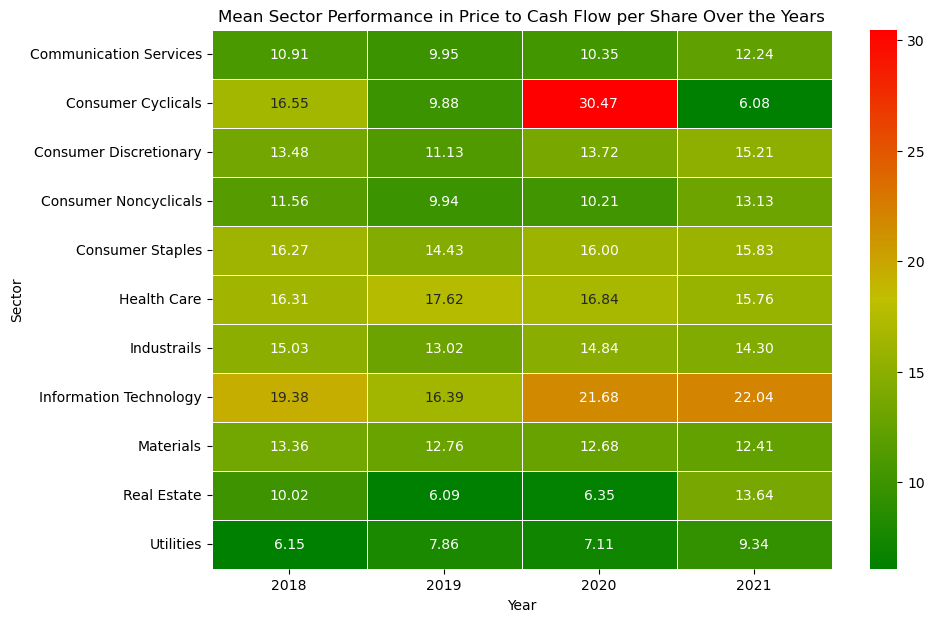

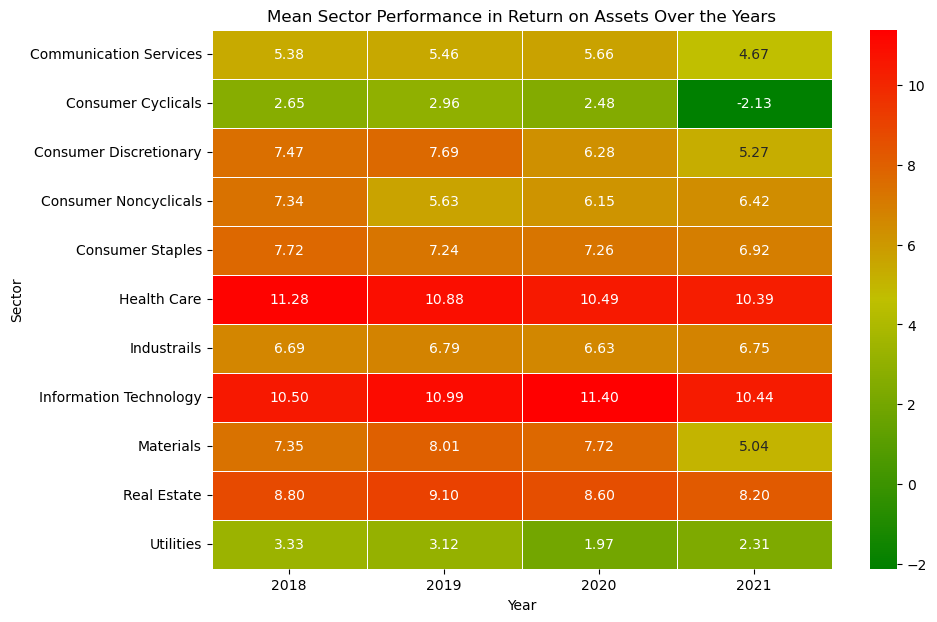

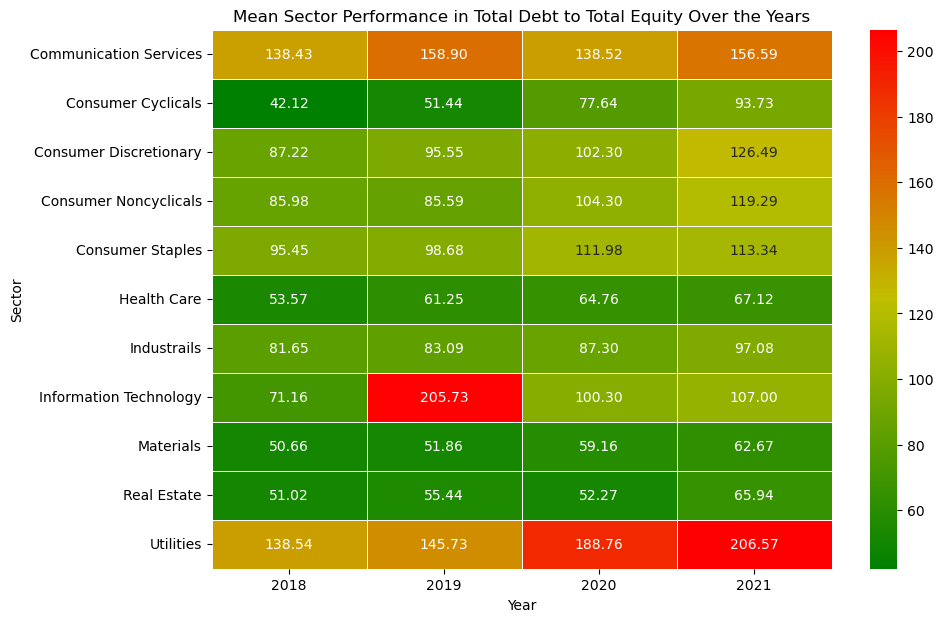

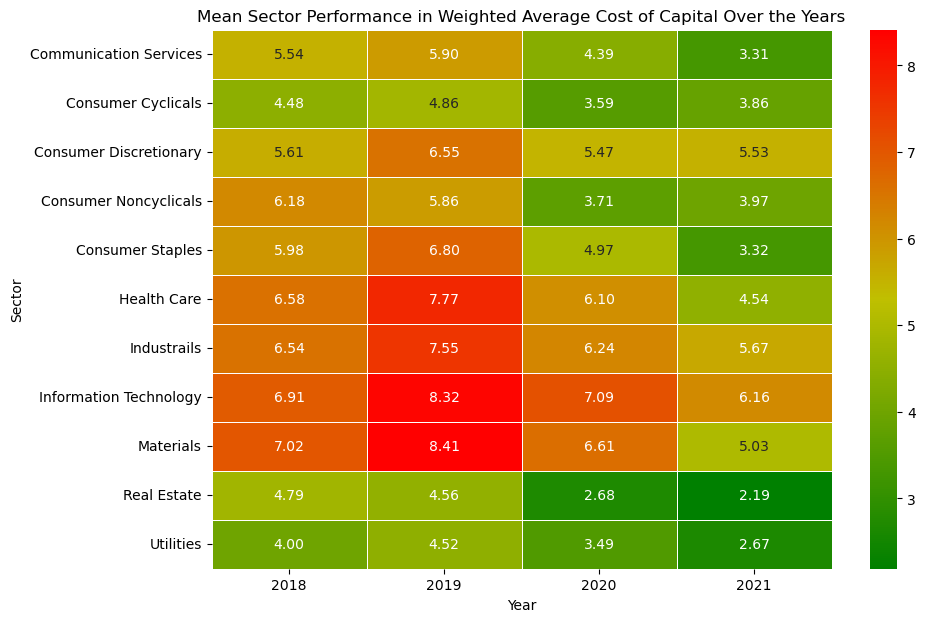

In [41]:
def plot_sector_performance(df, metrics):
    """
    Plots the sector performance over the years for the given metrics using a heatmap

    Parameters:
        df (pandas.DataFrame): The DataFrame containing sector and year information
        metrics (list): The list of metrics to plot

    Returns:
        None
    """
    df_sector_mean = df.groupby(['Year', 'Sector'])[metrics].mean()

    for metric in metrics:
        pivot_df = df_sector_mean[f'{metric}'].unstack(level=0)
        plt.figure(figsize=(10,7))
        cmap = LinearSegmentedColormap.from_list('gr',["g", "y", "r"], N=256) 
        sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap=cmap, linewidths=0.5)
        plt.title(f'Mean Sector Performance in {metric} Over the Years')
        plt.show()

plot_sector_performance(final_data, final_data.columns[1:])

/var/folders/9p/xr85g4y15w1fy3_389l3s_nh0000gn/T/ipykernel_86452/3289259431.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  line1 = final_data.groupby(['Year'])['Scope1','Scope2 Market','Scope2 Location'].mean()


Text(0.5, 1.0, 'Year over Year Comparison of Emissions')

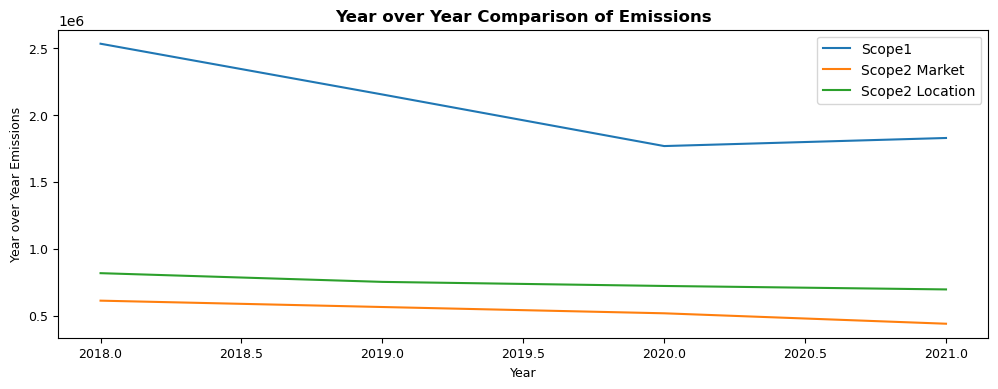

In [42]:
line1 = final_data.groupby(['Year'])['Scope1','Scope2 Market','Scope2 Location'].mean()
line1.plot(figsize=(12,4),fontsize=9)
plt.ylabel('Year over Year Emissions', fontsize = 9 )
plt.xlabel('Year', fontsize = 9)
plt.title('Year over Year Comparison of Emissions',fontsize = 12,fontweight='bold')

Text(0.5, 1.0, 'Sector-wise Comparison of Scope 2 Market Emissions')

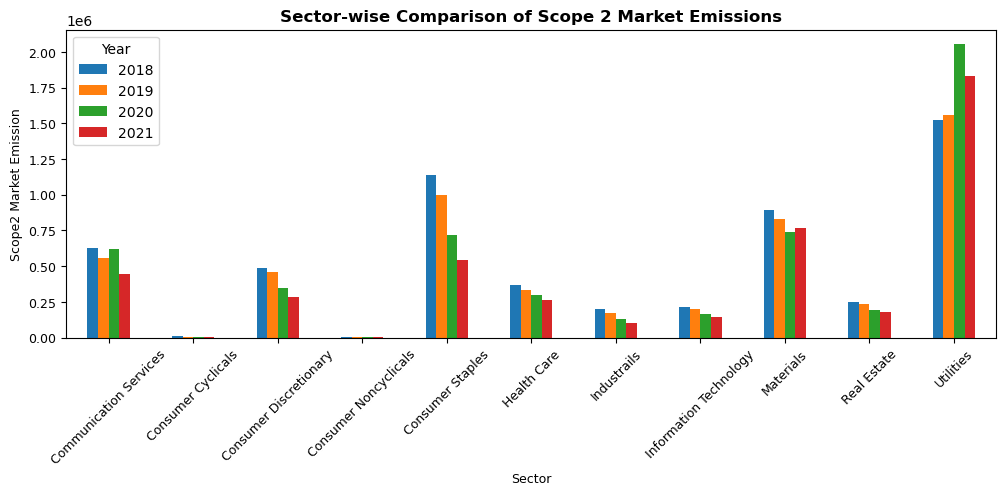

In [43]:
bar1 = final_data.groupby(['Sector','Year'])['Scope2 Market'].mean().unstack(level=1)
bar1.plot(kind='bar',figsize=(12,4),fontsize=9)
plt.ylabel('Scope2 Market Emission', fontsize = 9 )
plt.xlabel('Sector', fontsize = 9)
plt.xticks(rotation = 45)
plt.title('Sector-wise Comparison of Scope 2 Market Emissions',fontsize = 12,fontweight='bold')

Text(0.5, 1.0, 'Sector-wise Comparison of Scope 2 Location Emissions')

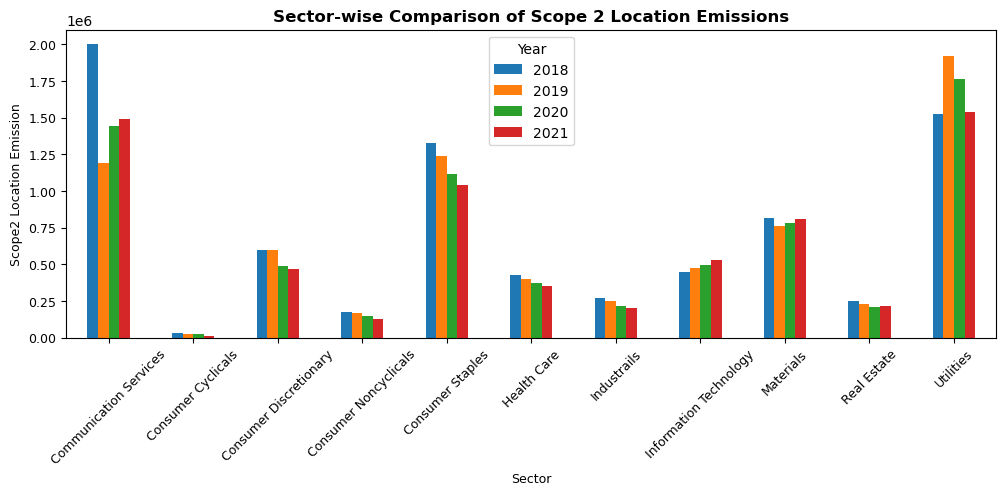

In [44]:
bar2 = final_data.groupby(['Sector','Year'])['Scope2 Location'].mean().unstack(level=1)
bar2.plot(kind='bar',figsize=(12,4),fontsize=9)
plt.ylabel('Scope2 Location Emission', fontsize = 9 )
plt.xlabel('Sector', fontsize = 9)
plt.xticks(rotation =45)
plt.title('Sector-wise Comparison of Scope 2 Location Emissions',fontsize = 12,fontweight='bold')

/var/folders/9p/xr85g4y15w1fy3_389l3s_nh0000gn/T/ipykernel_86452/4070084277.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bar3 = final_data.groupby(['Sector','Year'])['Scope1','Scope2 Market','Scope2 Location'].mean().unstack(level=1).T


Text(0.5, 1.0, 'Year over Year Emissions for Utilities Sector')

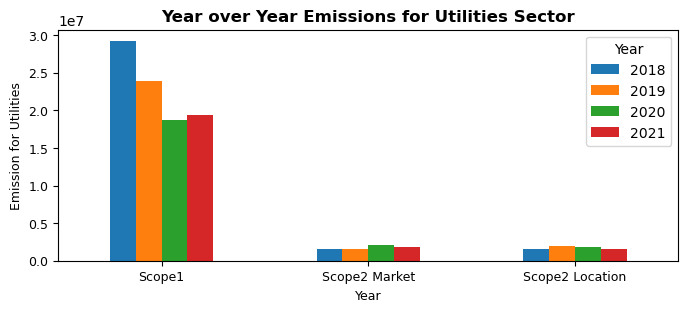

In [45]:
bar3 = final_data.groupby(['Sector','Year'])['Scope1','Scope2 Market','Scope2 Location'].mean().unstack(level=1).T
bar3 = bar3['Utilities'].unstack(level=-1)
bar3.plot(kind='bar',figsize=(8,3),fontsize=9)
plt.ylabel('Emission for Utilities', fontsize = 9 )
plt.xlabel('Year', fontsize = 9)
plt.xticks(rotation = 0)
plt.title('Year over Year Emissions for Utilities Sector',fontsize = 12,fontweight='bold')

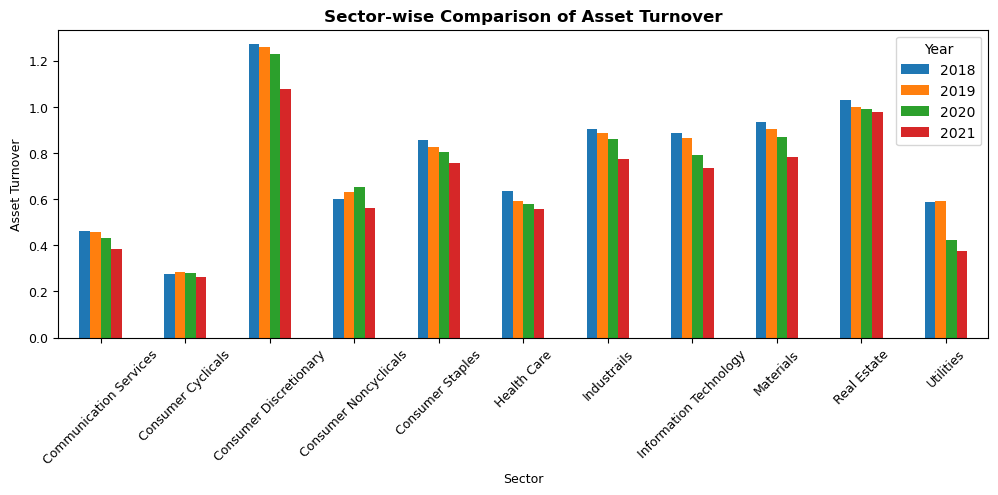

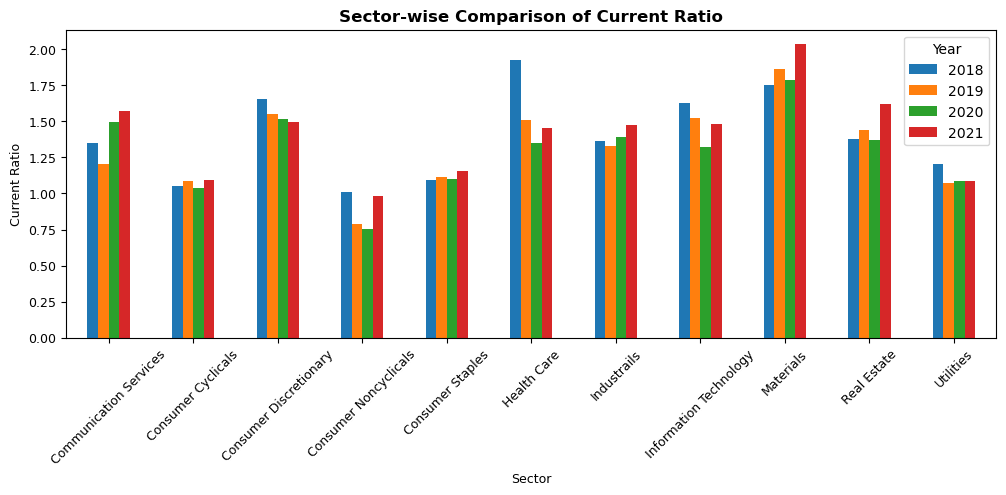

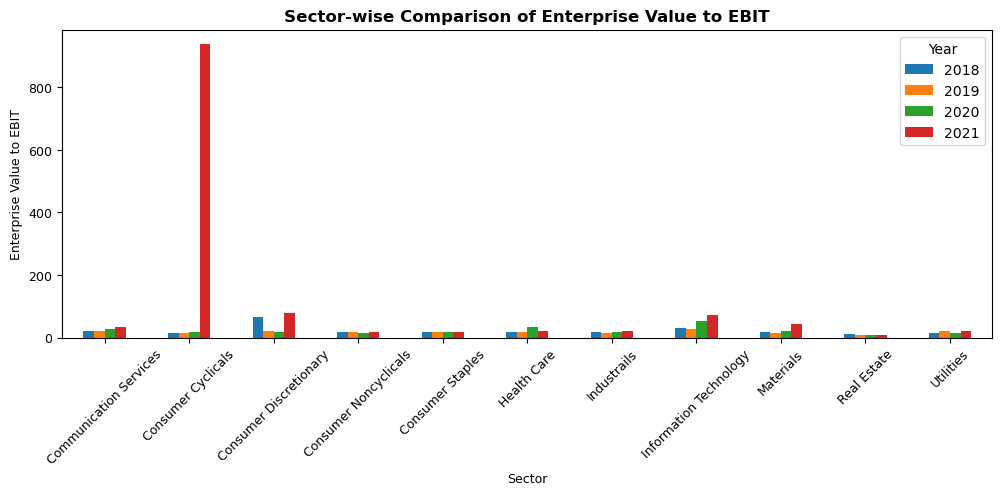

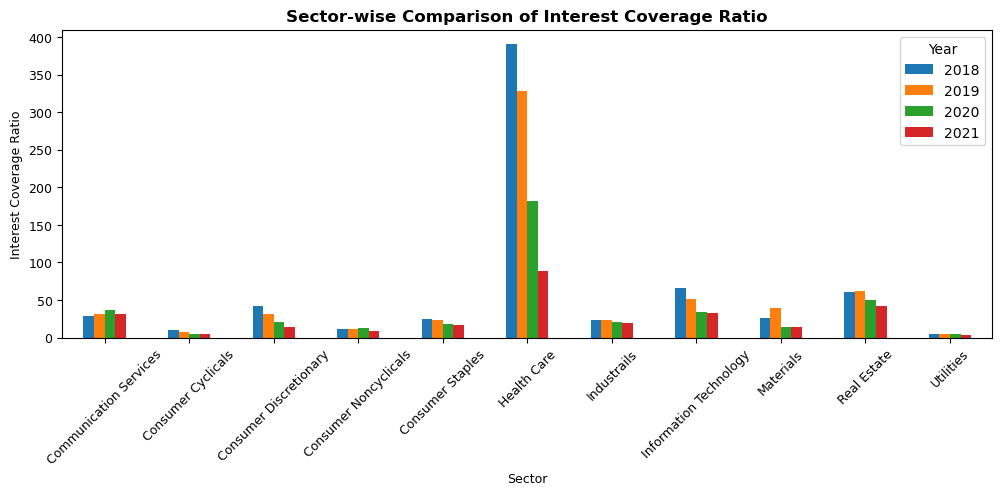

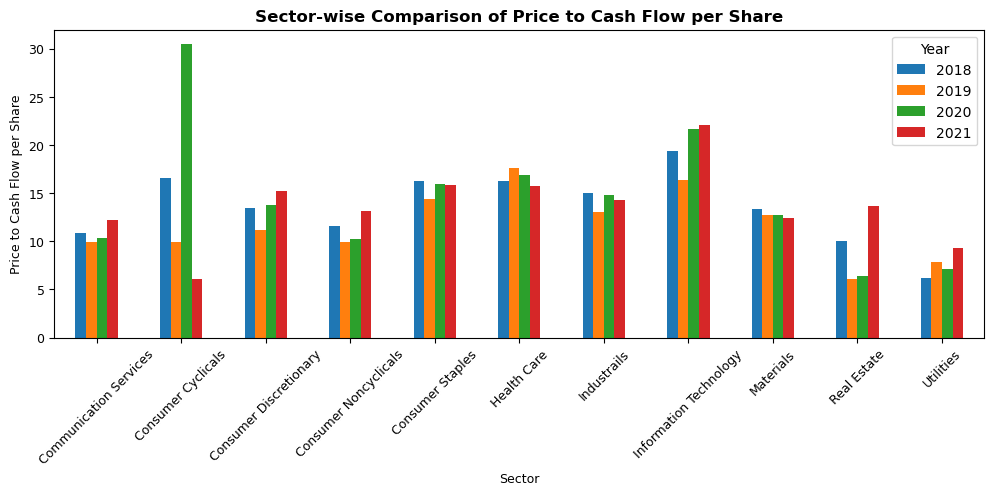

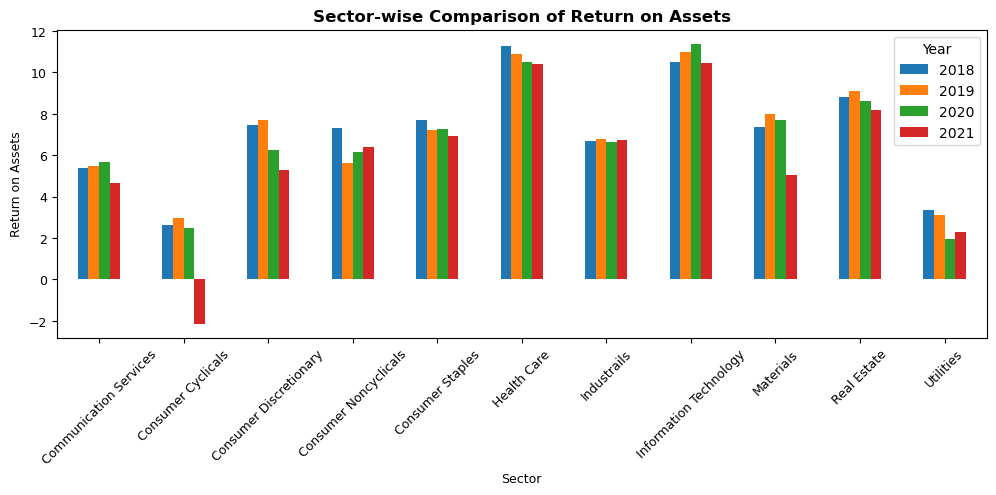

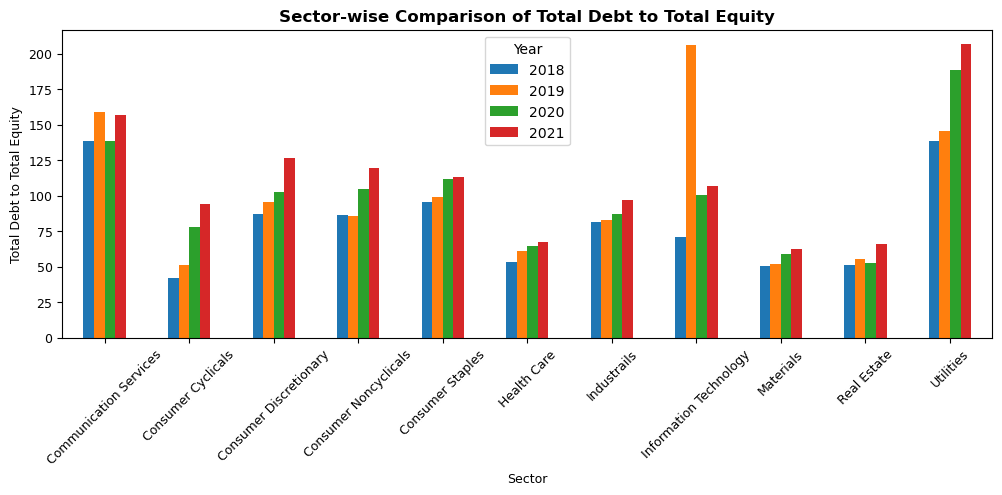

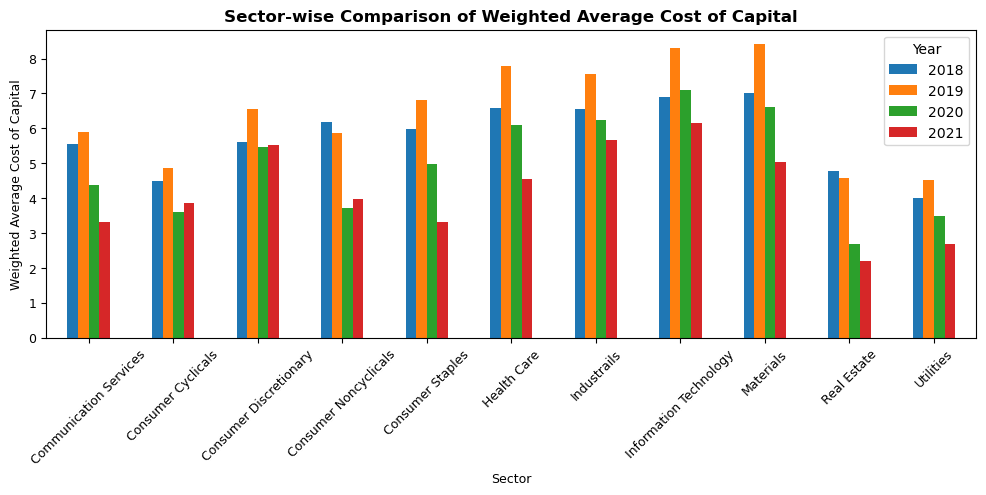

In [46]:
fin_metrics = ['Asset Turnover', 'Current Ratio', 'Enterprise Value to EBIT', 'Interest Coverage Ratio',
               'Price to Cash Flow per Share', 'Return on Assets' , 'Total Debt to Total Equity',
               'Weighted Average Cost of Capital']
for i in fin_metrics:
    bar4 = final_data.groupby(['Sector','Year'])[i].mean().unstack(level=1)
    bar4.plot(kind='bar',figsize=(12,4),fontsize=9)
    plt.ylabel(i, fontsize = 9 )
    plt.xlabel('Sector', fontsize = 9)
    plt.xticks(rotation =45)
    plt.title(f'Sector-wise Comparison of {i}' ,fontsize = 12,fontweight='bold')

## Regression

In [47]:
final_data.columns

Index(['Sector', 'Scope1', 'Scope2 Location', 'Scope2 Market',
       'Sum_Emission_Mkt', 'Sum_Emission_Loc', 'Asset Turnover',
       'Current Ratio', 'Enterprise Value to EBIT', 'Interest Coverage Ratio',
       'Price to Cash Flow per Share', 'Return on Assets',
       'Total Debt to Total Equity', 'Weighted Average Cost of Capital'],
      dtype='object')

In [48]:
# create a list of variables that you want to use as Xs
x_vars = ['Asset Turnover','Current Ratio', 'Enterprise Value to EBIT', 'Interest Coverage Ratio', 
          'Price to Cash Flow per Share', 'Return on Assets', 'Total Debt to Total Equity', 
          'Weighted Average Cost of Capital']
# add constant to Xs df
X = sm.add_constant(final_data[x_vars])

### METHOD 1

#### Model 1 -- Scope1

In [49]:
# create Y df
Y1 = np.log(final_data[['Scope1']])

# specify the model 
mod1 = PanelOLS(Y1, X)
res1 = mod1.fit()
print(res1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 Scope1   R-squared:                        0.1787
Estimator:                   PanelOLS   R-squared (Between):              0.2161
No. Observations:                 512   R-squared (Within):              -4.2813
Date:                Thu, Jun 15 2023   R-squared (Overall):              0.1787
Time:                        13:58:42   Log-likelihood                   -1122.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      13.678
Entities:                         128   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(8,503)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             13.678
                            

#### Model 2 -- Scope2 Location

In [50]:
# create Y df
Y2 = np.log(final_data[['Scope2 Location']])

# specify the model 
mod2 = PanelOLS(Y2, X)
res2 = mod2.fit()
print(res2)

                          PanelOLS Estimation Summary                           
Dep. Variable:        Scope2 Location   R-squared:                        0.1083
Estimator:                   PanelOLS   R-squared (Between):              0.1348
No. Observations:                 512   R-squared (Within):              -1.2580
Date:                Thu, Jun 15 2023   R-squared (Overall):              0.1083
Time:                        13:58:42   Log-likelihood                   -958.23
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.6332
Entities:                         128   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(8,503)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             7.6332
                            

#### Model 3 -- Scope 2 Market

In [51]:
# create Y df
Y3 = np.log(final_data[['Scope2 Market']])

# specify the model 
mod3 = PanelOLS(Y3, X)
res3 = mod3.fit()
print(res3)

                          PanelOLS Estimation Summary                           
Dep. Variable:          Scope2 Market   R-squared:                        0.1110
Estimator:                   PanelOLS   R-squared (Between):              0.1329
No. Observations:                 512   R-squared (Within):              -0.1193
Date:                Thu, Jun 15 2023   R-squared (Overall):              0.1110
Time:                        13:58:43   Log-likelihood                   -1105.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7.8467
Entities:                         128   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(8,503)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             7.8467
                            

#### Model 4 -- Sum of Scope1 and Scope2 Location

In [52]:
# create Y df
Y4 = np.log(final_data[['Sum_Emission_Loc']])

# specify the model 
mod4 = PanelOLS(Y4, X)
res4 = mod4.fit()
print(res4)

                          PanelOLS Estimation Summary                           
Dep. Variable:       Sum_Emission_Loc   R-squared:                        0.1624
Estimator:                   PanelOLS   R-squared (Between):              0.1966
No. Observations:                 512   R-squared (Within):              -2.8869
Date:                Thu, Jun 15 2023   R-squared (Overall):              0.1624
Time:                        13:58:43   Log-likelihood                   -1009.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      12.186
Entities:                         128   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(8,503)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             12.186
                            

#### Model 5 -- Sum of Scope1 and Scope2 Market

In [53]:
# create Y df
Y5 = np.log(final_data[['Sum_Emission_Mkt']])

# specify the model 
mod5 = PanelOLS(Y5, X)
res5 = mod5.fit()
print(res5)

                          PanelOLS Estimation Summary                           
Dep. Variable:       Sum_Emission_Mkt   R-squared:                        0.1649
Estimator:                   PanelOLS   R-squared (Between):              0.1996
No. Observations:                 512   R-squared (Within):              -1.5943
Date:                Thu, Jun 15 2023   R-squared (Overall):              0.1649
Time:                        13:58:43   Log-likelihood                   -1049.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      12.413
Entities:                         128   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(8,503)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             12.413
                            

#### Model Comparison

In [54]:
print(compare({"Model 1": res1, 
               "Model 2": res2, 
               "Model 3": res3, 
               "Model 4": res4, 
               "Model 5": res5}, stars=True).summary)

                                                    Model Comparison                                                   
                                        Model 1           Model 2         Model 3            Model 4            Model 5
-----------------------------------------------------------------------------------------------------------------------
Dep. Variable                            Scope1   Scope2 Location   Scope2 Market   Sum_Emission_Loc   Sum_Emission_Mkt
Estimator                              PanelOLS          PanelOLS        PanelOLS           PanelOLS           PanelOLS
No. Observations                            512               512             512                512                512
Cov. Est.                            Unadjusted        Unadjusted      Unadjusted         Unadjusted         Unadjusted
R-squared                                0.1787            0.1083          0.1110             0.1624             0.1649
R-Squared (Within)                      

In [55]:
summary1 = compare({"Model 1": res1, 
               "Model 2": res2, 
               "Model 3": res3, 
               "Model 4": res4, 
               "Model 5": res5}, stars=True).summary
with open('Regression_Summary1.csv','w') as f:
    f.write(summary1.as_csv())

### METHOD 2

In [56]:
final_data.columns = ['Sector','Scope1','Scope2_Location','Scope2_Market','Sum_Emission_Mkt','Sum_Emission_Loc',
                     'Asset_Turnover', 'Current_Ratio', 'Enterprise_Value_to_EBIT', 'Interest_Coverage_Ratio',
                     'Price_to_Cash_Flow_per_Share', 'Return_on_Assets' , 'Total_Debt_to_Total_Equity',
                     'Weighted_Average_Cost_of_Capital']

#### Model 1 -- Scope 1

In [57]:
model1 = PanelOLS.from_formula('log(Scope1) ~ Asset_Turnover + Current_Ratio + Enterprise_Value_to_EBIT + Interest_Coverage_Ratio + Price_to_Cash_Flow_per_Share + Return_on_Assets + Total_Debt_to_Total_Equity + Weighted_Average_Cost_of_Capital', data = final_data) 
results1 = model1.fit(cov_type='clustered', cluster_entity=True)
print(results1)

                          PanelOLS Estimation Summary                           
Dep. Variable:            log(Scope1)   R-squared:                        0.8843
Estimator:                   PanelOLS   R-squared (Between):              0.8989
No. Observations:                 512   R-squared (Within):              -43.927
Date:                Thu, Jun 15 2023   R-squared (Overall):              0.8843
Time:                        13:58:43   Log-likelihood                   -1451.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      481.71
Entities:                         128   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(8,504)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             232.02
                            

#### Model 2 -- Scope2 Location

In [58]:
model2 = PanelOLS.from_formula('log(Scope2_Location) ~ Asset_Turnover + Current_Ratio + Enterprise_Value_to_EBIT + Interest_Coverage_Ratio + Price_to_Cash_Flow_per_Share + Return_on_Assets + Total_Debt_to_Total_Equity + Weighted_Average_Cost_of_Capital', data = final_data) 
results2 = model2.fit(cov_type='clustered', cluster_entity=True)
print(results2)

                           PanelOLS Estimation Summary                            
Dep. Variable:     log(Scope2_Location)   R-squared:                        0.9156
Estimator:                     PanelOLS   R-squared (Between):              0.9292
No. Observations:                   512   R-squared (Within):              -38.764
Date:                  Thu, Jun 15 2023   R-squared (Overall):              0.9156
Time:                          13:58:43   Log-likelihood                   -1383.9
Cov. Estimator:               Clustered                                           
                                          F-statistic:                      683.55
Entities:                           128   P-value                           0.0000
Avg Obs:                         4.0000   Distribution:                   F(8,504)
Min Obs:                         4.0000                                           
Max Obs:                         4.0000   F-statistic (robust):             386.81
    

#### Model 3 -- Scope2 Market

In [59]:
model3 = PanelOLS.from_formula('log(Scope2_Market) ~ Asset_Turnover + Current_Ratio + Enterprise_Value_to_EBIT + Interest_Coverage_Ratio + Price_to_Cash_Flow_per_Share + Return_on_Assets + Total_Debt_to_Total_Equity + Weighted_Average_Cost_of_Capital', data = final_data) 
results3 = model3.fit(cov_type='clustered', cluster_entity=True)
print(results3)

                          PanelOLS Estimation Summary                           
Dep. Variable:     log(Scope2_Market)   R-squared:                        0.9047
Estimator:                   PanelOLS   R-squared (Between):              0.9197
No. Observations:                 512   R-squared (Within):              -3.9114
Date:                Thu, Jun 15 2023   R-squared (Overall):              0.9047
Time:                        13:58:43   Log-likelihood                   -1386.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      598.26
Entities:                         128   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                   F(8,504)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             423.76
                            

#### Model 4 -- Sum of Scope 1 and Scope2 Location

In [60]:
model4 = PanelOLS.from_formula('log(Sum_Emission_Loc) ~ Asset_Turnover + Current_Ratio + Enterprise_Value_to_EBIT + Interest_Coverage_Ratio + Price_to_Cash_Flow_per_Share + Return_on_Assets + Total_Debt_to_Total_Equity + Weighted_Average_Cost_of_Capital', data = final_data) 
results4 = model4.fit(cov_type='clustered', cluster_entity=True)
print(results4)

                            PanelOLS Estimation Summary                            
Dep. Variable:     log(Sum_Emission_Loc)   R-squared:                        0.9084
Estimator:                      PanelOLS   R-squared (Between):              0.9224
No. Observations:                    512   R-squared (Within):              -59.504
Date:                   Thu, Jun 15 2023   R-squared (Overall):              0.9084
Time:                           13:58:43   Log-likelihood                   -1435.2
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      625.03
Entities:                            128   P-value                           0.0000
Avg Obs:                          4.0000   Distribution:                   F(8,504)
Min Obs:                          4.0000                                           
Max Obs:                          4.0000   F-statistic (robust):            

#### Model 5 -- Sum of Scope 1 and Scope2 Market

In [61]:
model5 = PanelOLS.from_formula('log(Sum_Emission_Mkt) ~ Asset_Turnover + Current_Ratio + Enterprise_Value_to_EBIT + Interest_Coverage_Ratio + Price_to_Cash_Flow_per_Share + Return_on_Assets + Total_Debt_to_Total_Equity + Weighted_Average_Cost_of_Capital', data = final_data) 
results5 = model5.fit(cov_type='clustered', cluster_entity=True)
print(results5)

                            PanelOLS Estimation Summary                            
Dep. Variable:     log(Sum_Emission_Mkt)   R-squared:                        0.9042
Estimator:                      PanelOLS   R-squared (Between):              0.9181
No. Observations:                    512   R-squared (Within):              -27.240
Date:                   Thu, Jun 15 2023   R-squared (Overall):              0.9042
Time:                           13:58:44   Log-likelihood                   -1435.0
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      594.79
Entities:                            128   P-value                           0.0000
Avg Obs:                          4.0000   Distribution:                   F(8,504)
Min Obs:                          4.0000                                           
Max Obs:                          4.0000   F-statistic (robust):            

### Model Comparison

In [62]:
compare({"Model 1": results1, 
         "Model 2": results2, 
         "Model 3": results3, 
         "Model 4": results4, 
         "Model 5": results5}, stars=True).summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                                                              Model Comparison                                                              
============================================================================================================================================
                                         Model 1                Model 2              Model 3                 Model 4                 Model 5
--------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                        log(Scope1)   log(Scope2_Location)   log(Scope2_Market)   log(Sum_Emission_Loc)   log(Sum_Emission_Mkt)
Estimator                               PanelOLS               PanelOLS             PanelOLS                PanelOLS                PanelOLS
No. Observations                             512                    512                  512                     512                     512
Cov. Est.                              Clustered              Clustered            Clustered               Clustered               Clustered
R-squared                                 0.8843                 0.9156               0.9047                  0.9084                  0.9042
R-Squared (Within)                       -43.927                -38.764              -3.9114                 -59.504                 -27.240
R-Squared (Between)                       0.8989                 0.9292               0.9197                  0.9224                  0.9181
R-Squared (Overall)                       0.8843                 0.9156               0.9047                  0.9084                  0.9042
F-statistic                               481.71                 683.55               598.26                  625.03                  594.79
P-value (F-stat)                          0.0000                 0.0000               0.0000                  0.0000                  0.0000
================================== ============= ====================== ==================== ======================= =======================
Asset_Turnover                         2.0125***              1.9415***            2.1341***               2.0896***               2.1922***
                                        (2.8417)               (2.9848)             (3.2344)                (2.9924)                (3.0938)
Current_Ratio                          1.9672***              2.0431***            1.8472***               2.2169***               2.1545***
                                        (4.5516)               (6.2419)             (5.4509)                (5.8043)                (5.4649)
Enterprise_Value_to_EBIT                  0.0007               0.0040**              0.0035*                0.0034**                  0.0028
                                        (0.4154)               (2.4095)             (1.8376)                (1.9802)                (1.5892)
Interest_Coverage_Ratio                  -0.0006              -0.0006**              -0.0002               -0.0006**                 -0.0005
                                       (-1.6387)              (-2.0266)            (-0.6682)               (-2.0110)               (-1.6231)
Price_to_Cash_Flow_per_Share             -0.0001                 0.0137               0.0067                  0.0117                  0.0083
                                       (-0.0045)               (0.6038)             (0.2802)                (0.4717)                (0.3326)
Return_on_Assets                         -0.0047                 0.0364              -0.0429                  0.0179                 -0.0099
                                       (-0.0920)               (0.7857)            (-0.7529)                (0.3682)               (-0.1949)
Total_Debt_to_Total_Equity               0.0127*                0.0122*             0.0117**                 0.0136*                 0.0134

In [63]:
summary2 = compare({"Model 1": results1, 
                    "Model 2": results2, 
                    "Model 3": results3, 
                    "Model 4": results4, 
                    "Model 5": results5}, stars=True).summary
with open('Regression_Summary2.csv','w') as f:
    f.write(summary2.as_csv())

---